#### Group D: Noah Syrkis Brunken (nobr@itu.dk), Patrick Herlin Henriksen (pahe@itu.dk) and Astrid Machholm (astma@itu.dk)
#### Course: Network Analysis
#### Course code: BSNEANA1KU

# Analysis of the Gnutella Network

Gnutella was a p2p file-sharing network from the early 2000s.
The network functioned as a distributed alternative to
centralised file indexes, meaning its purpose was to allow file querying,
i.e. answering the question: "is this file available on a computer
somewhere on the network and, if so, where?"

Thus "Gnutella" refers to at least two interesting networks:
- The network connections between computers allowing for this type of querying.
- The network of who downloaded what file from whom.

Our network is the former: Nodes are consumer laptops and desktops,
and edges are connections between these, representing paths through which
file request queries could move. The edges are directed (each computer had
a list of computers to which it would relay queries). These query request and responses are called ping-pong. When a node requests a file, it pings its neighbours, asks if they have the file, and the neighbour then asks its neighbours. This keeps going until the file has been found or the message's TTL ('time to live', which is the number of hops a query can make before it stops) has been reached, in which the last node pinged will send a request back, a pong, with either "here is the file" or "no file". With this in mind, we
posed the following question of our data: **how robust is the Gnutella
network to attacks?**

We believe robustness is a relevant aspect of the network due to it
being an indication of how useful the network was and how hard
it would be to shut down (much of the activity on the network was
illegal file sharing). The latter we attempt to answer by performing attacks
on the network based on various metrics.

Our data consists of nine snapshots of the Gnutella network, crawled at different
days of August 2002, totalling to more than 190.000 nodes and about
500.000 edges. So as to make the analysis more viable with the size of the
network in mind, we precomputed various network properties and stored
the results into .json files for quick use.

<a id='contents'></a>
## Table of Contents
- [Imports](#imports)
- [Json Data](#reading)
- [Analysis](#analysis)
    - [Network Over Time](#timeseries)
    - [Degree Distribution](#degdist)
    - [Clustering](#cluster)
    - [Fitting](#fitting)
    - [Centrality](#centrality)
        - [Betweenness Centrality](#betweenness)
        - [Closeness Centrality](#closeness)
        - [Eigenvector Centrality](#eigenvector)
    - [Other metrics](#others)
    - [Robustness](#robustness)
- [Conclusion](#conclusion)
- [Bibliography](#bibliography)
- [Future Work](#future)
- [Appendix](#appendix)


<a id='imports'></a>

## Imports

The following libraries were used in our analysis:

In [1]:
# native python
import json
import os
import warnings
warnings.filterwarnings("ignore")                    # get rid of annoying warnings
import sys; sys.path.append('../bin/')
import itertools
from collections import Counter

# third party
from tqdm import tqdm
import powerlaw
import numpy as np
import networkx as nx
import random

# plotting
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams["figure.dpi"] = 200
import seaborn as sns; sns.set()

<a id='reading'></a>
## Json Data

We construct .json files for each of the 9 graphs. The .json files each contain a dictionary of pre-computed properties. The schema for each dictionary file is as follows:

We load each .json file into a dictionary of dictionaries calling it `D`:

In [2]:
recompute = False        # set to True to recompute json files. Will take many many hours

def compute():
    os.system('python ../bin/metrics.py')

def use_json():
    D = {}
    targets = sorted(os.listdir('../data/dumps/'))
    targets = [target for target in targets if target[-1] == 'n']
    dumps = [f"../data/dumps/{target}" for target in targets]
    for i in range(len(dumps)):
        with open(dumps[i], 'r') as data_file:
            data = json.load(data_file)
            title = targets[i]
            data['name'] = title.split('.')[0]
            D[i] = data
    return D

compute() if recompute else None

D = use_json()

We also construct a dictionary of actual networkx graph objects and call it `S`:

In [3]:
path = '../data/graphs/'
targets = sorted([path + target for target in os.listdir(path) if target[-1] == 't'])
S = {idx: nx.read_edgelist(target, delimiter="\t", create_using=nx.DiGraph(name='test')) \
     for idx, target in enumerate(targets)}
for idx, G in enumerate(S):
    S[G].name = targets[idx][-6:-4] + '-08-2002'

Throughout the analysis, we need a null model for comparison. We use this null model to check if something is an artefact of the degree distributions itself, or if something can only be observed for our network specifically.

Our null model of choice is a configuration model. It has the same degree distribution as the original network, but nodes are connected randomly. When generating the configuration model, some node pairs end up with multiple links between them. To avoid analysis on a multigraph, we delete these multiple edges and create a simple digraph. This process alters the degree distribution a little. We can observe this in the degree centrality plot.

We create a dictionary `C` of configuration models:

In [4]:
C = {}
for i in range(len(S)):
    in_degs = list(dict(S[i].in_degree()).values())
    out_degs = list(dict(S[i].out_degree()).values())
    G = nx.directed_configuration_model(in_degs, out_degs)
    G = nx.DiGraph(G)
    C[i] = G

<a id='analysis'></a>
## Analysis

Initially, we perform some exploratory data analysis,
plotting degree distributions, centrality measures,
as well as power law fittings. This is done to better
understand the overall structure of the network,
as well as providing context through which
to understand the attack analysis.


Lastly, we plot the network robustness by removing nodes using various heuristics (randomly, by degree, etc.).

As our network is, in fact, nine snapshots of Gnutella
at different points in time, our plots will consist of 9
subplots each, so as to determine what seems to remain true across
time and what does not.

With this intention in mind, we create a plotter function that
we will use throughout this notebook:

In [5]:
dates = [4, 5, 6, 8, 9, 24, 25, 30, 31]
def plotter(plot_specific_execution, title):
    fig, axes = plt.subplots(3, 3, figsize=(16, 16))  # create 3 x 3 subplots
    i = 0                                             # incrementer to loop though all 9 graph data
    for ax in axes:
        for ay in ax:
            exec(f"{plot_specific_execution}")                       # plot specific function call
            ay.legend(); ay.set_title(D[i]['name'])
            i += 1
    plt.suptitle(title)
    plt.show()

<a id='timeseries'></a>
### Network Over Time



We plot the progression of the number of nodes and edges of the networks over time:

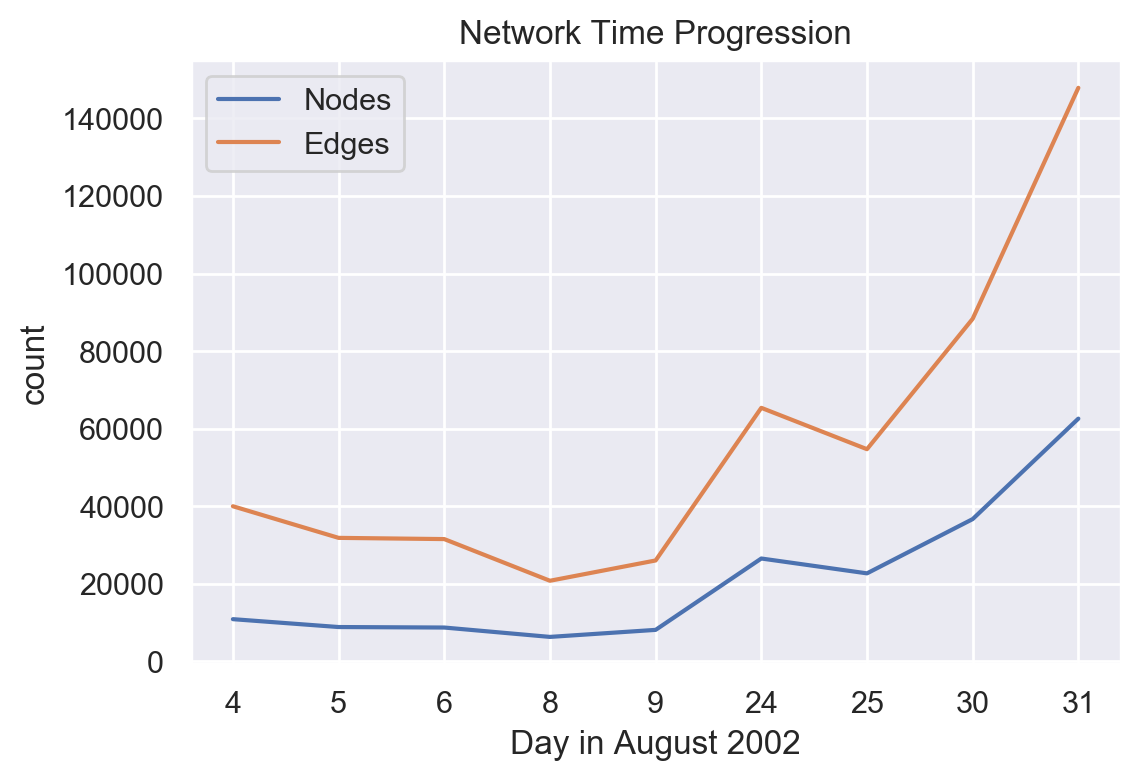

In [6]:
N = [len(G.nodes()) for G in S.values()]
E = [len(G.edges()) for G in S.values()]
plt.plot(N, label='Nodes'); plt.plot(E, label='Edges'); plt.title('Network Time Progression')
plt.xticks([i for i in range(9)], dates)
plt.xlabel('Day in August 2002'); plt.ylabel('count'); plt.legend();

As our network data is not the full Gnutella network but a snapshot of it, it is unknown whether the change in network size is an artefact of the scraping or an actual change in network size. This casts doubt on the validity of our analysis.

<a id='degdist'></a>
### Degree distribution

We plot the degree distribution of each graph in a log-log scale with logarithmic binning:

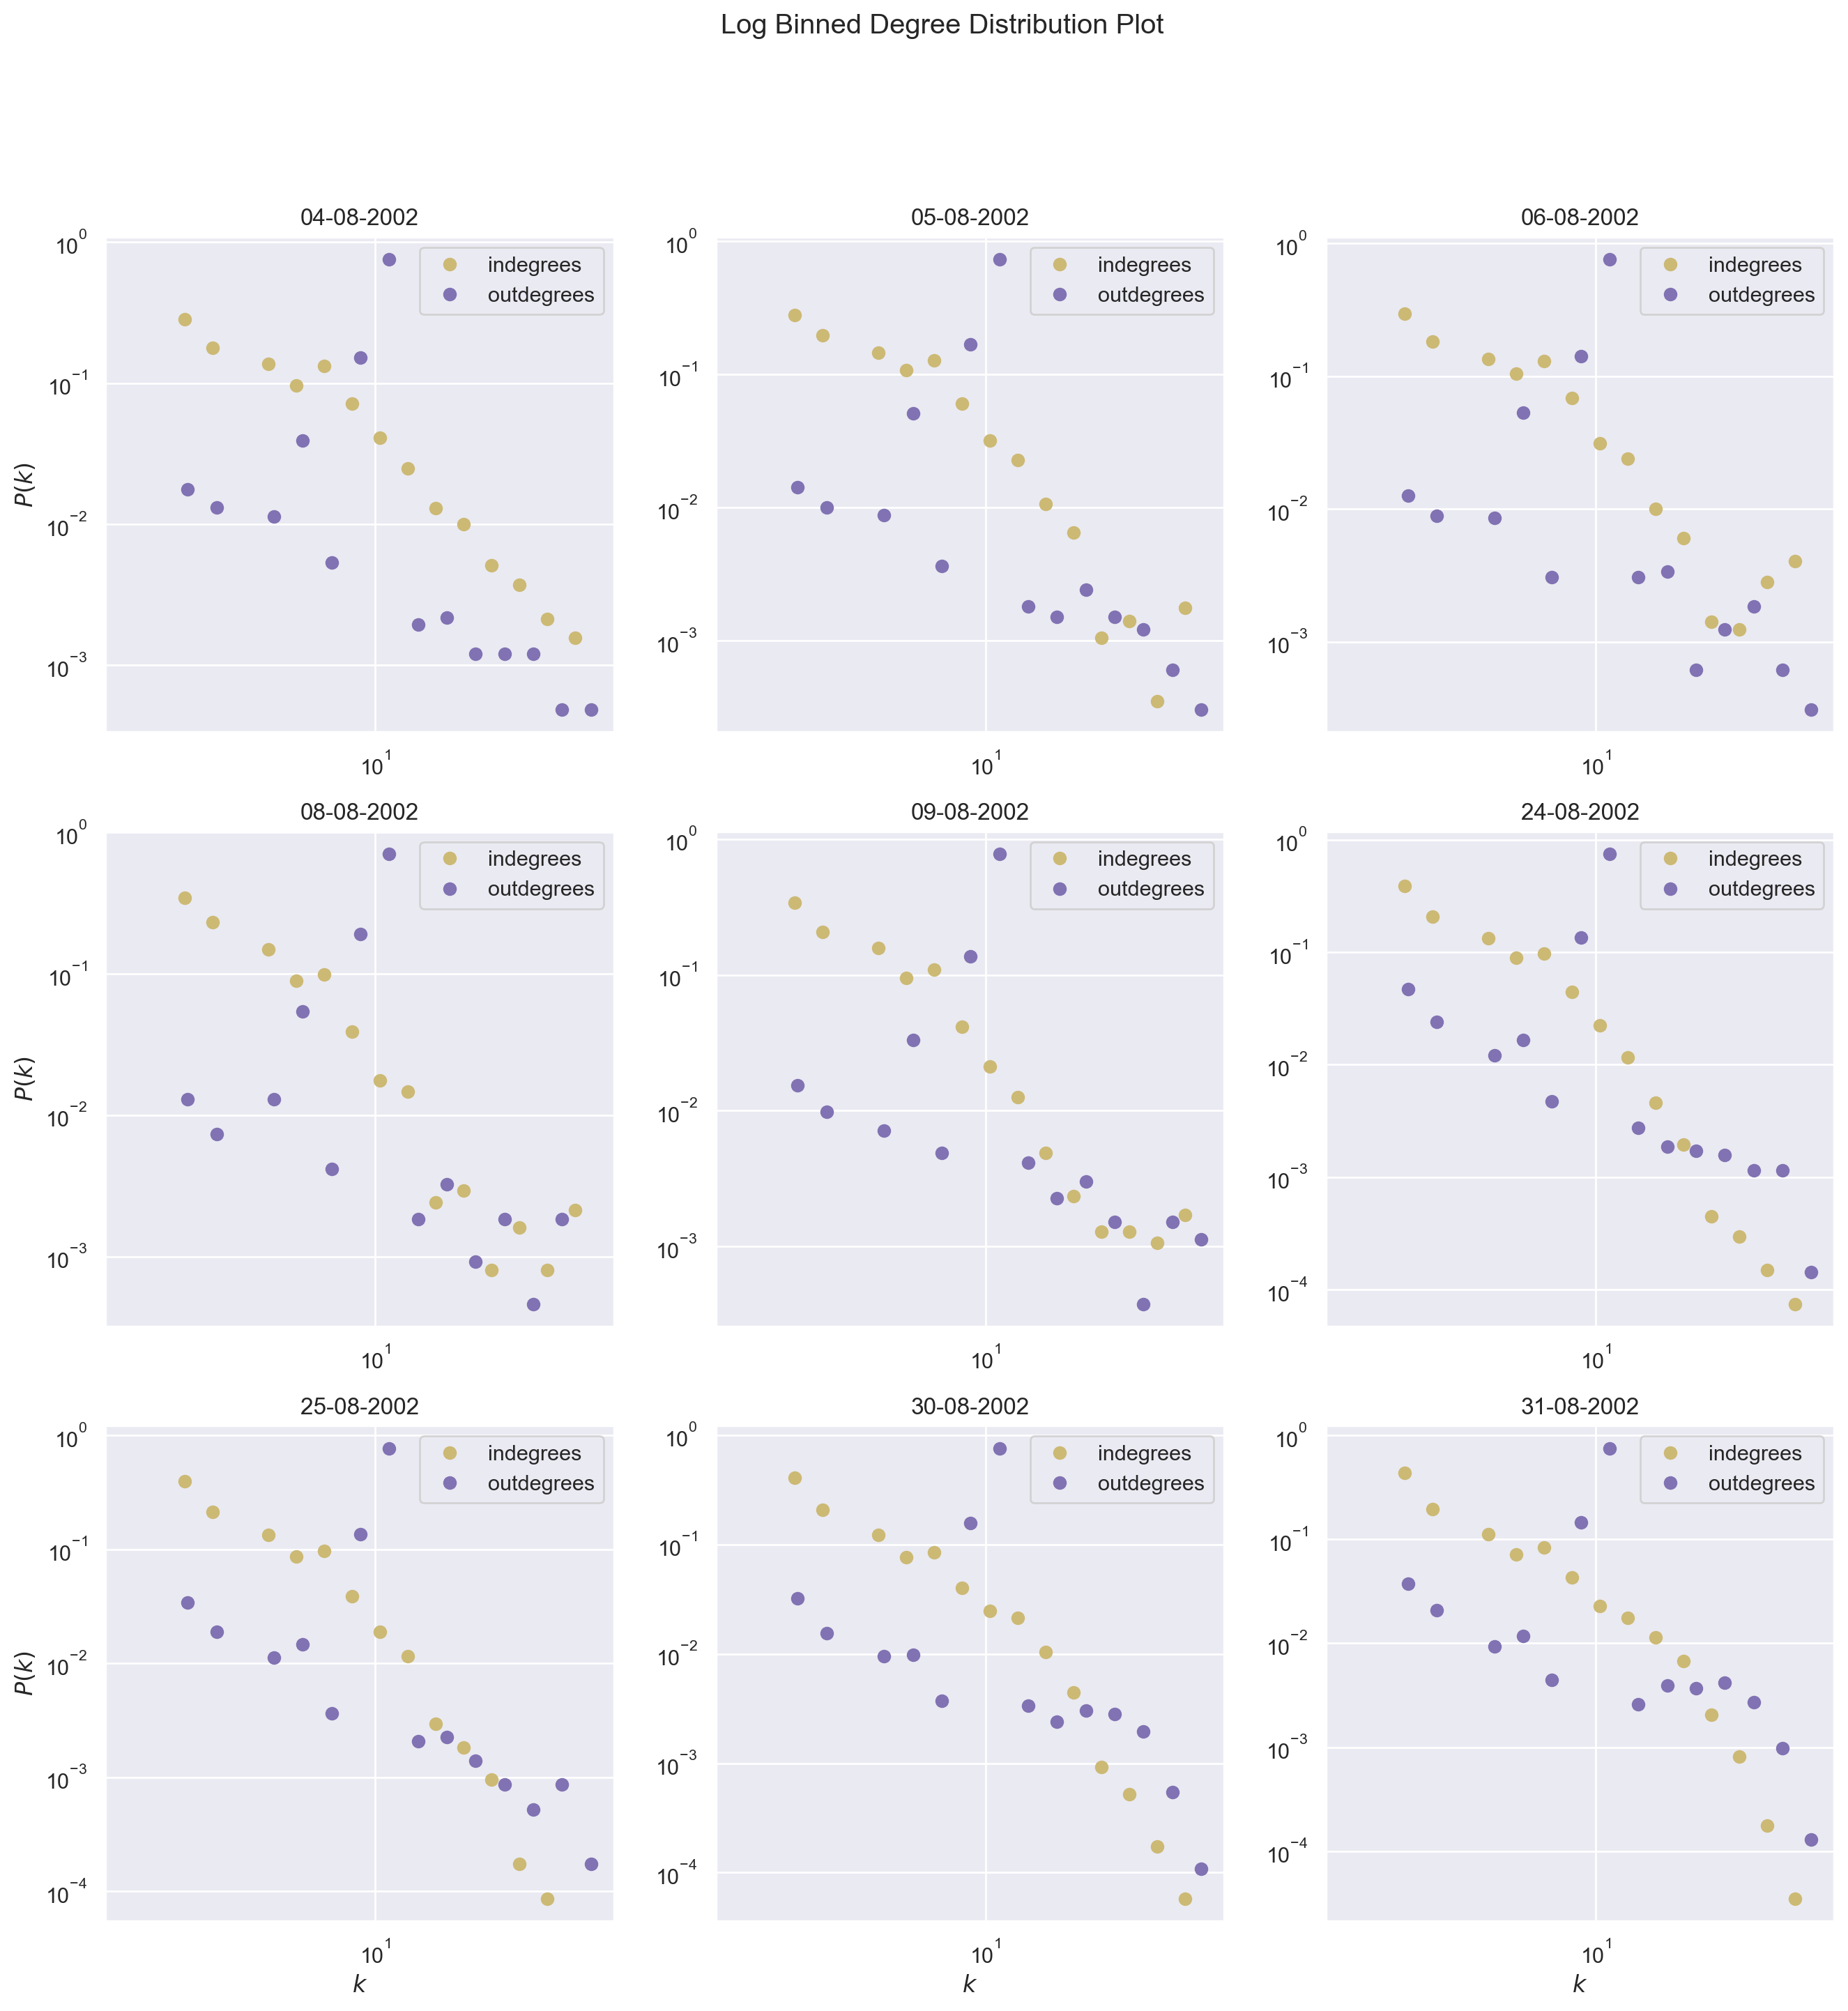

In [7]:
def degdist(ay, i):
    in_vals = list(dict(S[i].in_degree()).values())
    out_vals = list(dict(S[i].out_degree()).values())
    
    in_weights = np.ones_like(in_vals) / (len(in_vals))
    out_weights = np.ones_like(out_vals) / (len(out_vals))

    in_bins=np.logspace(np.log10(1), np.log10(max(in_degs)), num = 20 )
    out_bins=np.logspace(np.log10(1), np.log10(max(out_degs)), num = 20 )
    
    in_n, in_x, _ = ay.hist(in_vals,  bins=in_bins, weights=in_weights, log = True); ay.cla()
    out_n, out_x, _ = ay.hist(out_vals,  bins=out_bins, weights=out_weights, log = True); ay.cla()   
    
    in_bins = 0.5*(in_x[1:]+in_x[:-1])[1:-1]
    out_bins = 0.5*(out_x[1:]+out_x[:-1])[1:-1]
    
    in_n = [n / sum(in_n[1:]) for n in in_n[1:-1]]
    out_n = [n / sum(out_n[1:]) for n in out_n[1:-1]]
    
    ay.plot(in_bins, in_n, 'yo', label='indegrees')
    ay.plot(out_bins, out_n, 'mo', label='outdegrees')
    
    ay.set_yscale("log"); ay.set_xscale("log")
    if i >= 6:
        ay.set_xlabel(r'$k$')
    if i in [0, 3, 6]:
        ay.set_ylabel(r'$P(k)$')

plotter("degdist(ay, i)", 'Log Binned Degree Distribution Plot')                            # function call line for previously defined plotter function

As can be seen, there is a spike in outdegree frequency around 10. This looks highly artificial to us. The spike is most apparent in the linearly binned plot (found in the appendix at the end of this notebook). One possible explanation of the spike could be that of it being an artefact of the way the network was crawled. However, this remains speculation. While investigating the spike, we found out that the network has something called super-seeders. Super-seeders are part of a rule agreed upon when entering the network: Super-seeders are other nodes in the network. When you join the network, you must connect to at least one super-seeder. This explains some of the high degrees seen in the degree distribution and additionally gives insight into the attack we will do at the end. Because of this property of the network, we expect an attack on degree to be highly effective if aiming to dismantle the network.

We also want to calculate the first and second moment. This can be used to further understand the network and could be needed along with fitting to determine what which properties it inherits.

In [8]:
firstMoment = []
secondMoment = []
def number_moment(g,n):
    degree_sum = np.array(list(dict(g.degree).values()))
    return sum(degree_sum)/len(degree_sum), sum(degree_sum**n)/len(g)

def smallest_degree(g):
    smallestList = []
    for network in g:
        smallestDegree = 100
        for node in g[network].degree():
            if node[1] < smallestDegree:
                smallestDegree = node[1]
        smallestList.append(smallestDegree)
    return smallestList

for key in S:
    first, second = number_moment(S[key],2)
    firstMoment.append(first)
    secondMoment.append(second)
    
smallDegreeList = smallest_degree(S)

print(np.mean(firstMoment))
print(np.mean(secondMoment))

6.0097126737013875
84.30977216659716


Here we have the average first- and second moment of the 9 networks. The relatively large value of the second moment, indicates that, though perhaps still within the random paradigm, the networks degree distribution is in the direction of that of the scale-free. This will be explored further in the fitting plots.

<a id='cluster'></a>
### Clustering

Next, we plot the distribution of clustering coefficients in log-log scale with logarithmic binning.

The clustering coefficient is calculated based on the Watts-Strogatz definition:

$$ C_i = \frac{2L_i}{k_i(k_i-1)}$$

where $L_i$ is the number of links between the i'th node's neighbours, and $k_i$ is the number of neighbours.

Given our network’s purpose, having highly connected neighbouring nodes is inefficient as it could flood the network (neighbours would receive the same query from multiple sources (query duplicates)). We want to see if our network has this redundancy by looking at the clustering coefficients.

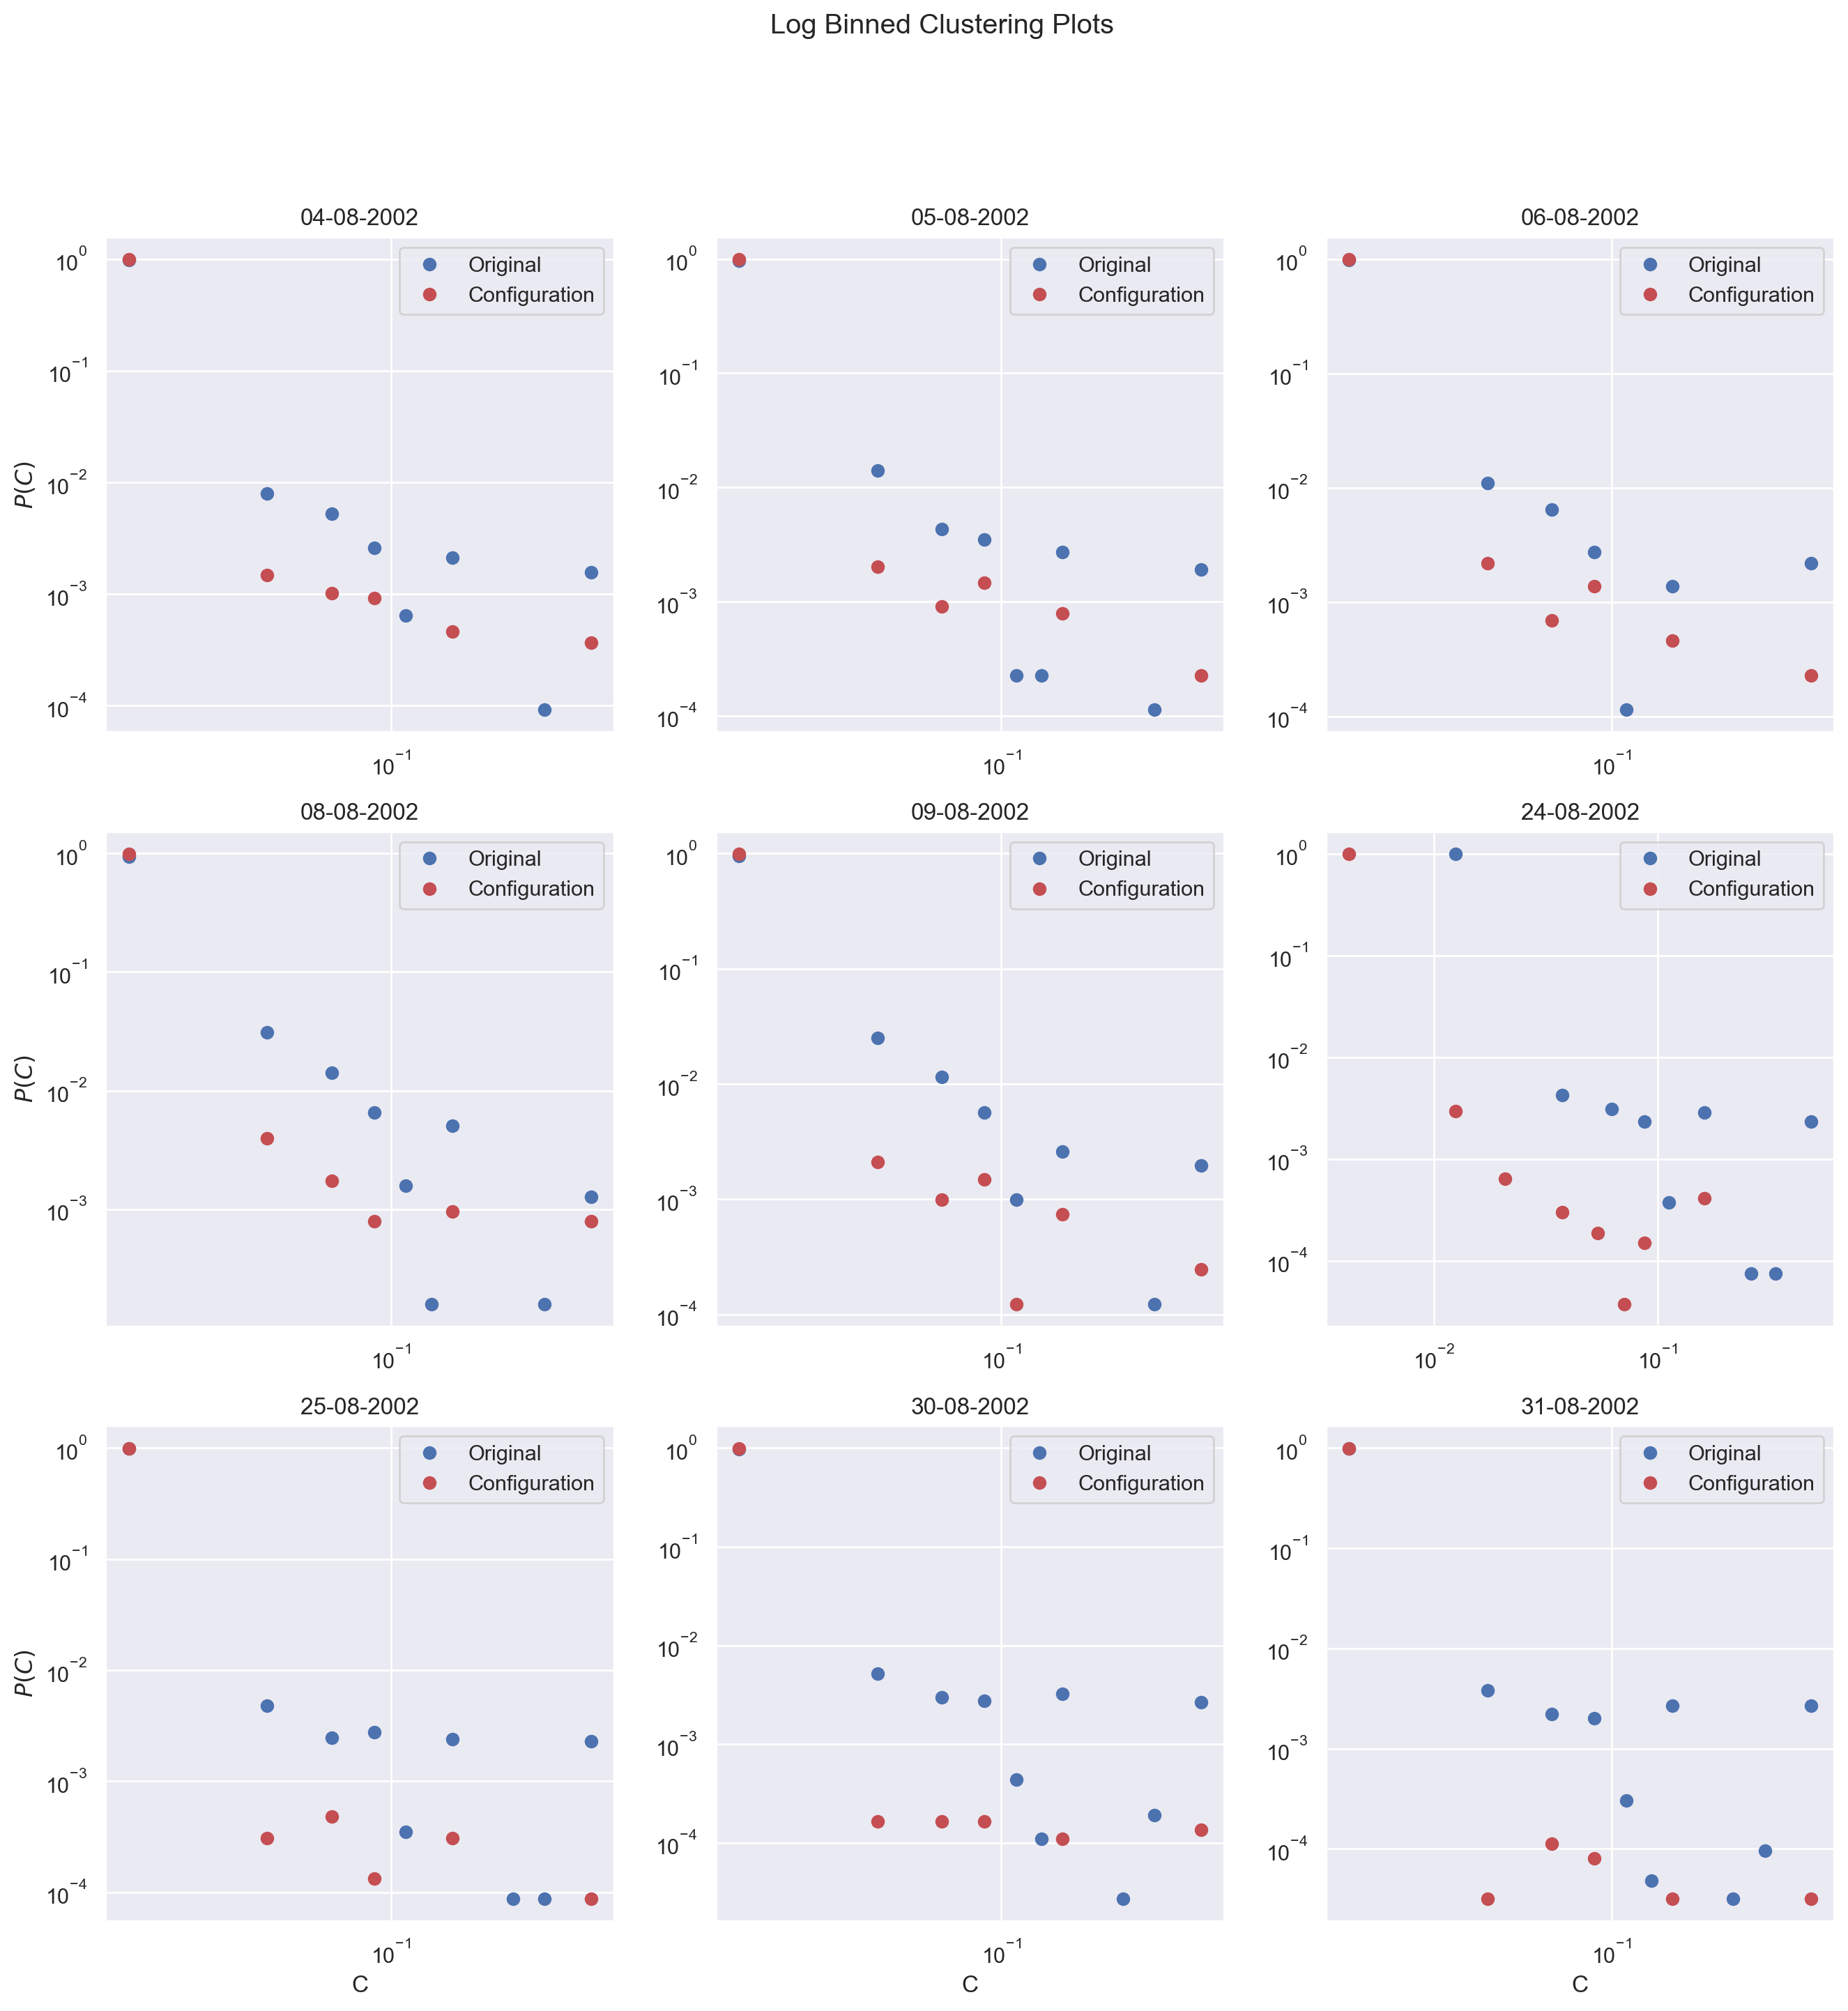

In [9]:
def cluster(ay, i):
    graph = S[i]
    confi = C[i]
    
    g_data = list(dict(Counter(nx.clustering(graph))).values())
    c_data = list(dict(Counter(nx.clustering(confi))).values())

    g_w = np.ones_like(g_data) / (len(g_data))
    c_w = np.ones_like(c_data) / (len(c_data))

    g_n, g_x, _ = ay.hist(g_data,  bins=20, weights=g_w); ay.cla()
    c_n, c_x, _ = ay.hist(c_data,  bins=20, weights=c_w); ay.cla()
    
    g_b = 0.5 * (g_x[1:]+g_x[:-1]);
    c_b = 0.5 * (c_x[1:]+c_x[:-1]);
    
    #mask = np.where(np.array(g_n) != 0)
    ay.set_yscale("log"), ay.set_xscale("log")
    
    ay.plot(g_b, g_n, 'bo', label='Original')
    ay.plot(c_b, c_n, 'ro', label='Configuration')
    if i >= 6:
        ay.set_xlabel(r'C')
    if i in [0, 3, 6]:
        ay.set_ylabel(r'$P(C)$')
    
plotter('cluster(ay, i)', 'Log Binned Clustering Plots')           # execute clustering plot

Looking at the clustering plots, it could look like some clustering coefficients have a frequency of 1. This is only a result of the log-log scale. The frequencies do, in fact, sum to one; thus, we can assume that plot captures the clustering coefficients correctly.

Clustering is reliably lower for the configuration model, and thus the clustering of the network is not a function of the degree distribution, but is instead significantly higher than we would expect. We have little intuition as to why, and find this finding surprising due to the potential drawback of clustering mentioned above.

<a id='fitting'></a>
### Fitting


In addition to the degree distribution plot, we want to identify which regime the network follows. If we can determine which regime/fit our network follows, we can assume it inherits the same properties, thus giving us a better understanding of our network.


In [10]:
def fitting(ay, i, in_degree = True):
    dists = ['power_law', 'exponential', 'truncated_power_law']
    degs = S[i].in_degree if in_degree else S[i].out_degree
    degs = np.array(list(dict(degs).values()))[19:-19]
    mask = (degs != max(degs))
    degs = degs[mask]
    
    fit = powerlaw.Fit(degs, ax=ay, verbose=False)
    fit.plot_ccdf(ax=ay, label='CCDF', color='b', linestyle='--', marker='o')
    fit.exponential.plot_ccdf(ax=ay, color='g', linestyle='--', label='exponential fit')
    fit.truncated_power_law.plot_ccdf(ax=ay, color='r', linestyle='--', label='Powerlaw w. exp. cutoff')
    fit.power_law.plot_ccdf(ax=ay, color='y', linestyle=':', label='power-law fit', marker='X')
    #fit.lognormal.plot_ccdf(ax=ay, color='c', linestyle='--', label='log-normal fit')
    # no log normal fit due to underflow error https://github.com/jeffalstott/powerlaw/pull/23
    sep = '\n' if (i + 1) % 3 == 0 else '\t\t' 
    print(f"{D[i]['name']} gamma  :  {round(fit.alpha, 3)}", end=sep)
          
    if i >= 6:
        ay.set_xlabel(r'$x$')
    if i in [0, 3, 6]:
        ay.set_ylabel(r'$P(k >= x)$')

We plot the in-degree fitting:

04-08-2002 gamma  :  3.905		05-08-2002 gamma  :  3.727		06-08-2002 gamma  :  3.768
08-08-2002 gamma  :  3.43		09-08-2002 gamma  :  3.572		24-08-2002 gamma  :  6.531
25-08-2002 gamma  :  6.383		30-08-2002 gamma  :  7.61		31-08-2002 gamma  :  6.4


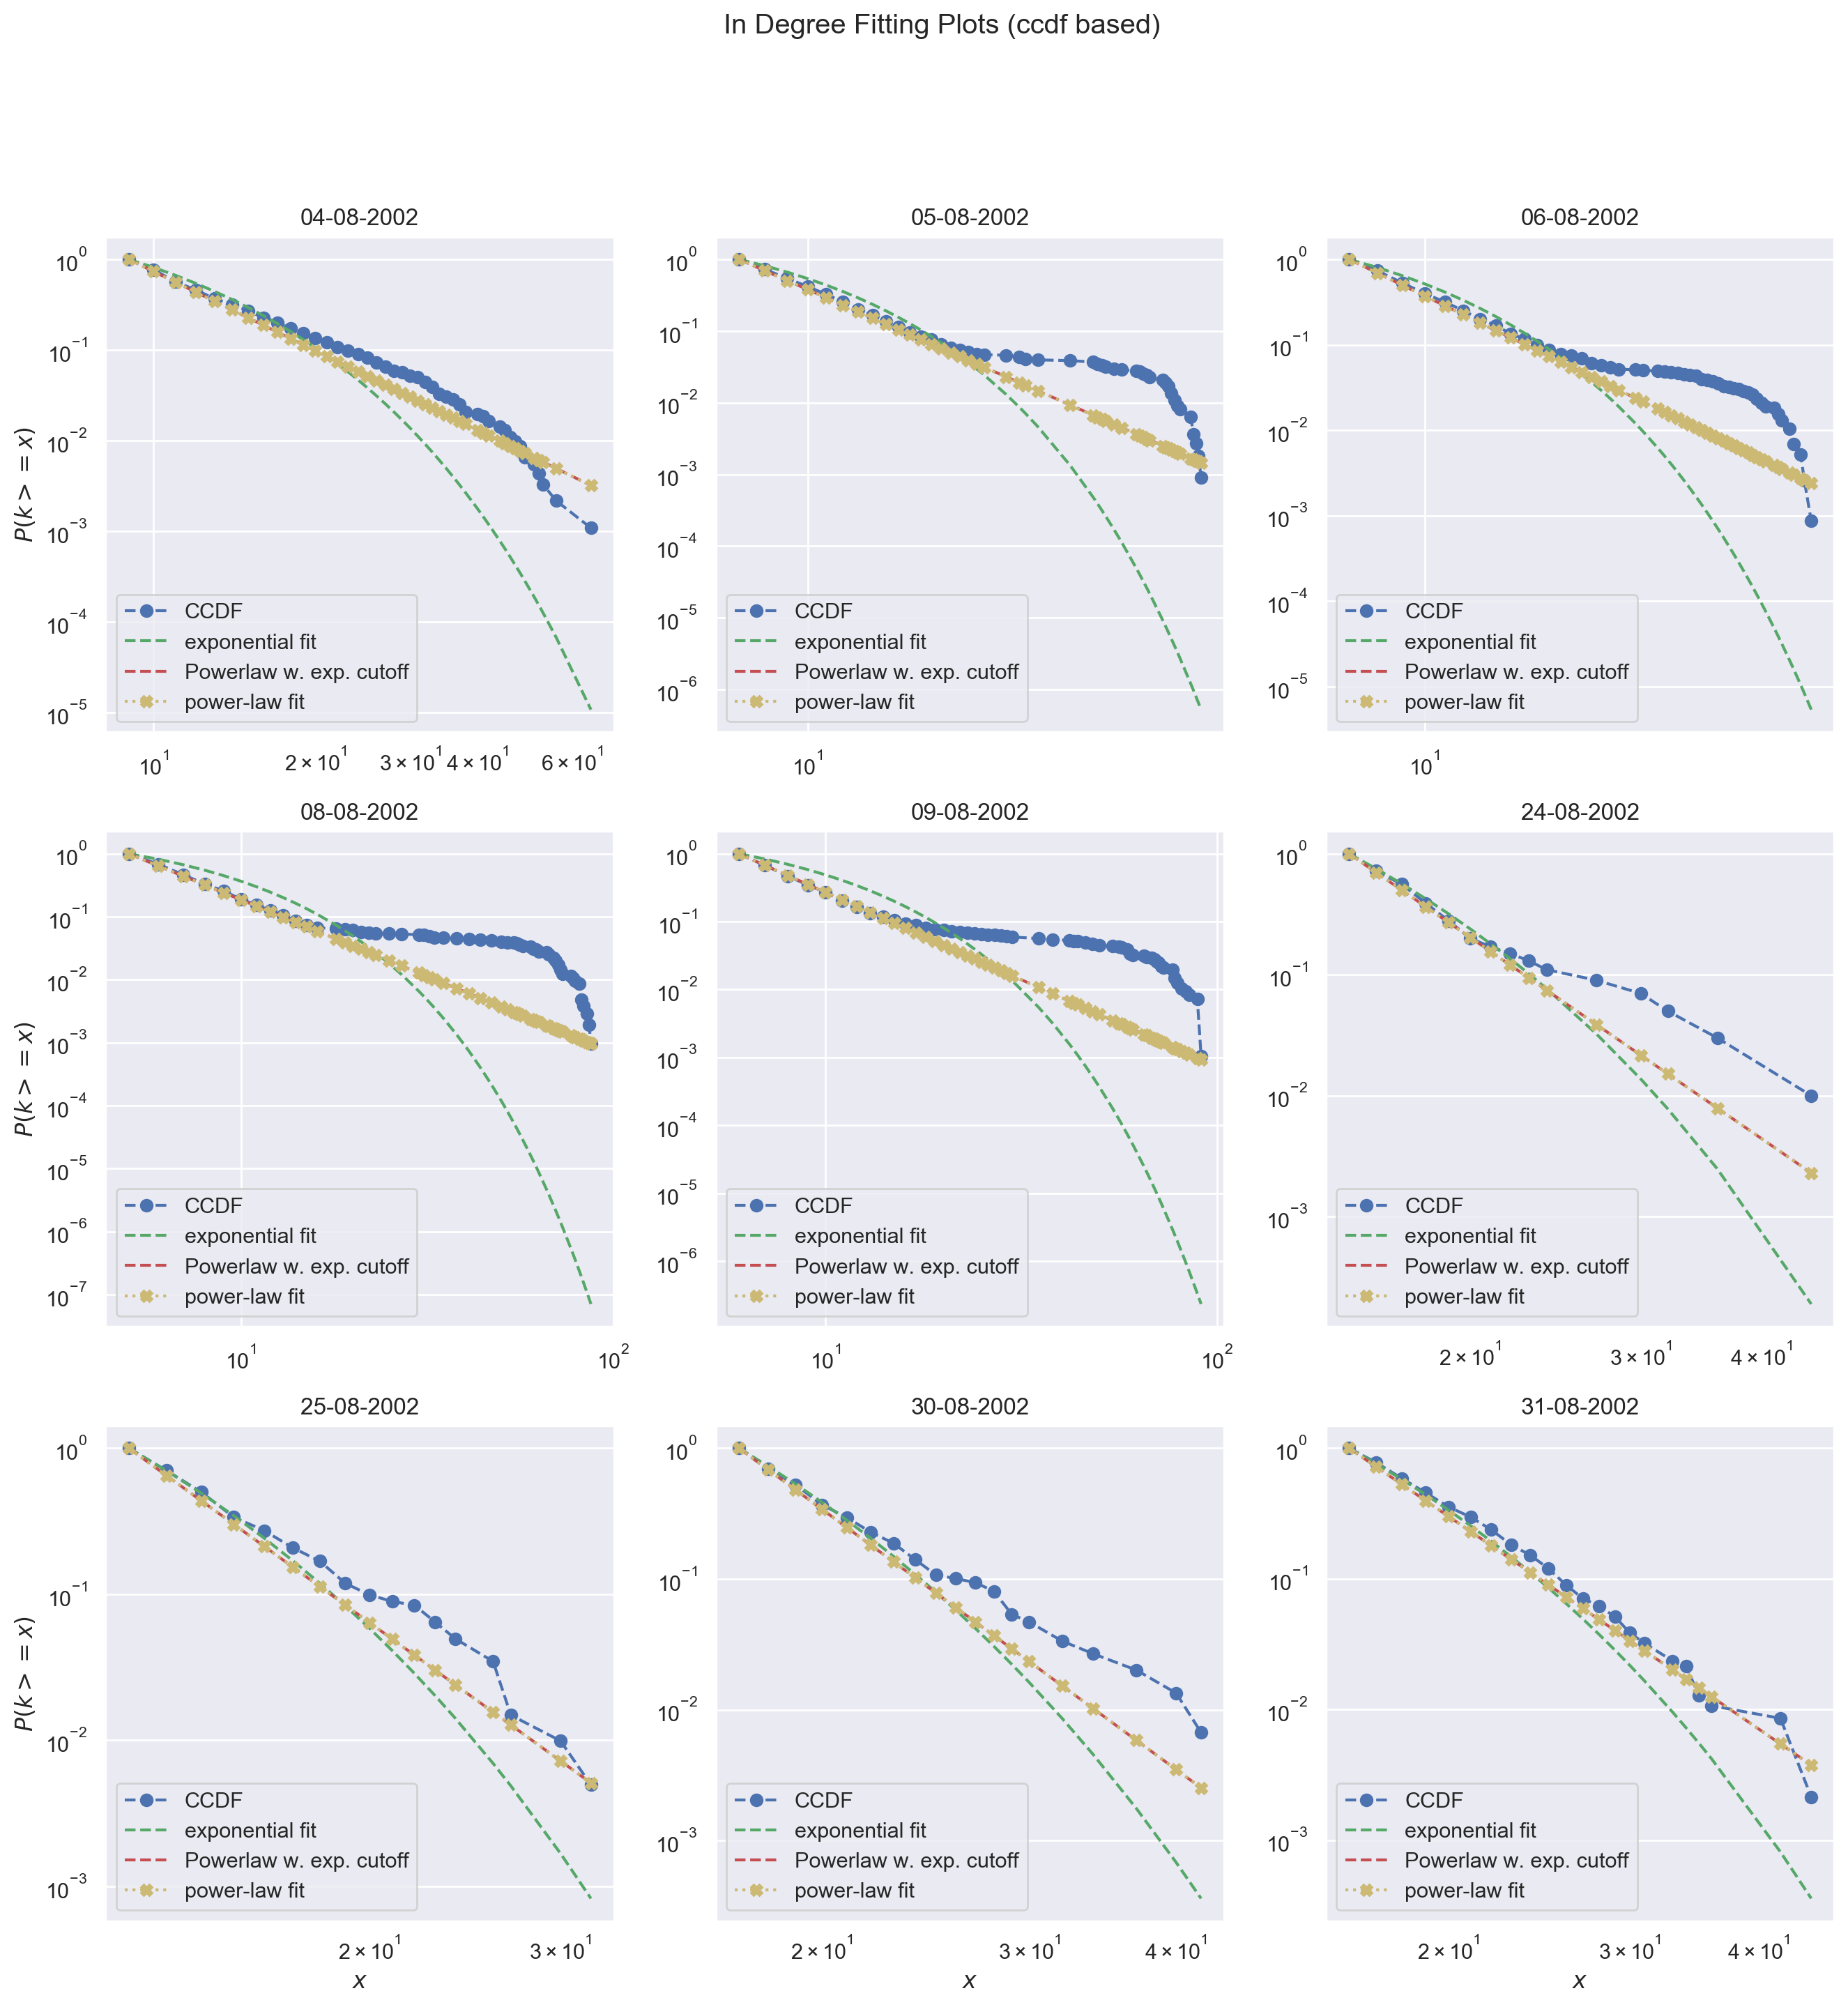

In [11]:
plotter('fitting(ay, i, True)', 'In Degree Fitting Plots (ccdf based)')           # execute fitting plot

We plot the out-degree fitting:

04-08-2002 gamma  :  97.323		05-08-2002 gamma  :  90.785		06-08-2002 gamma  :  92.188
08-08-2002 gamma  :  90.394		09-08-2002 gamma  :  73.625		24-08-2002 gamma  :  86.585
25-08-2002 gamma  :  120.056		30-08-2002 gamma  :  69.271		31-08-2002 gamma  :  49.304


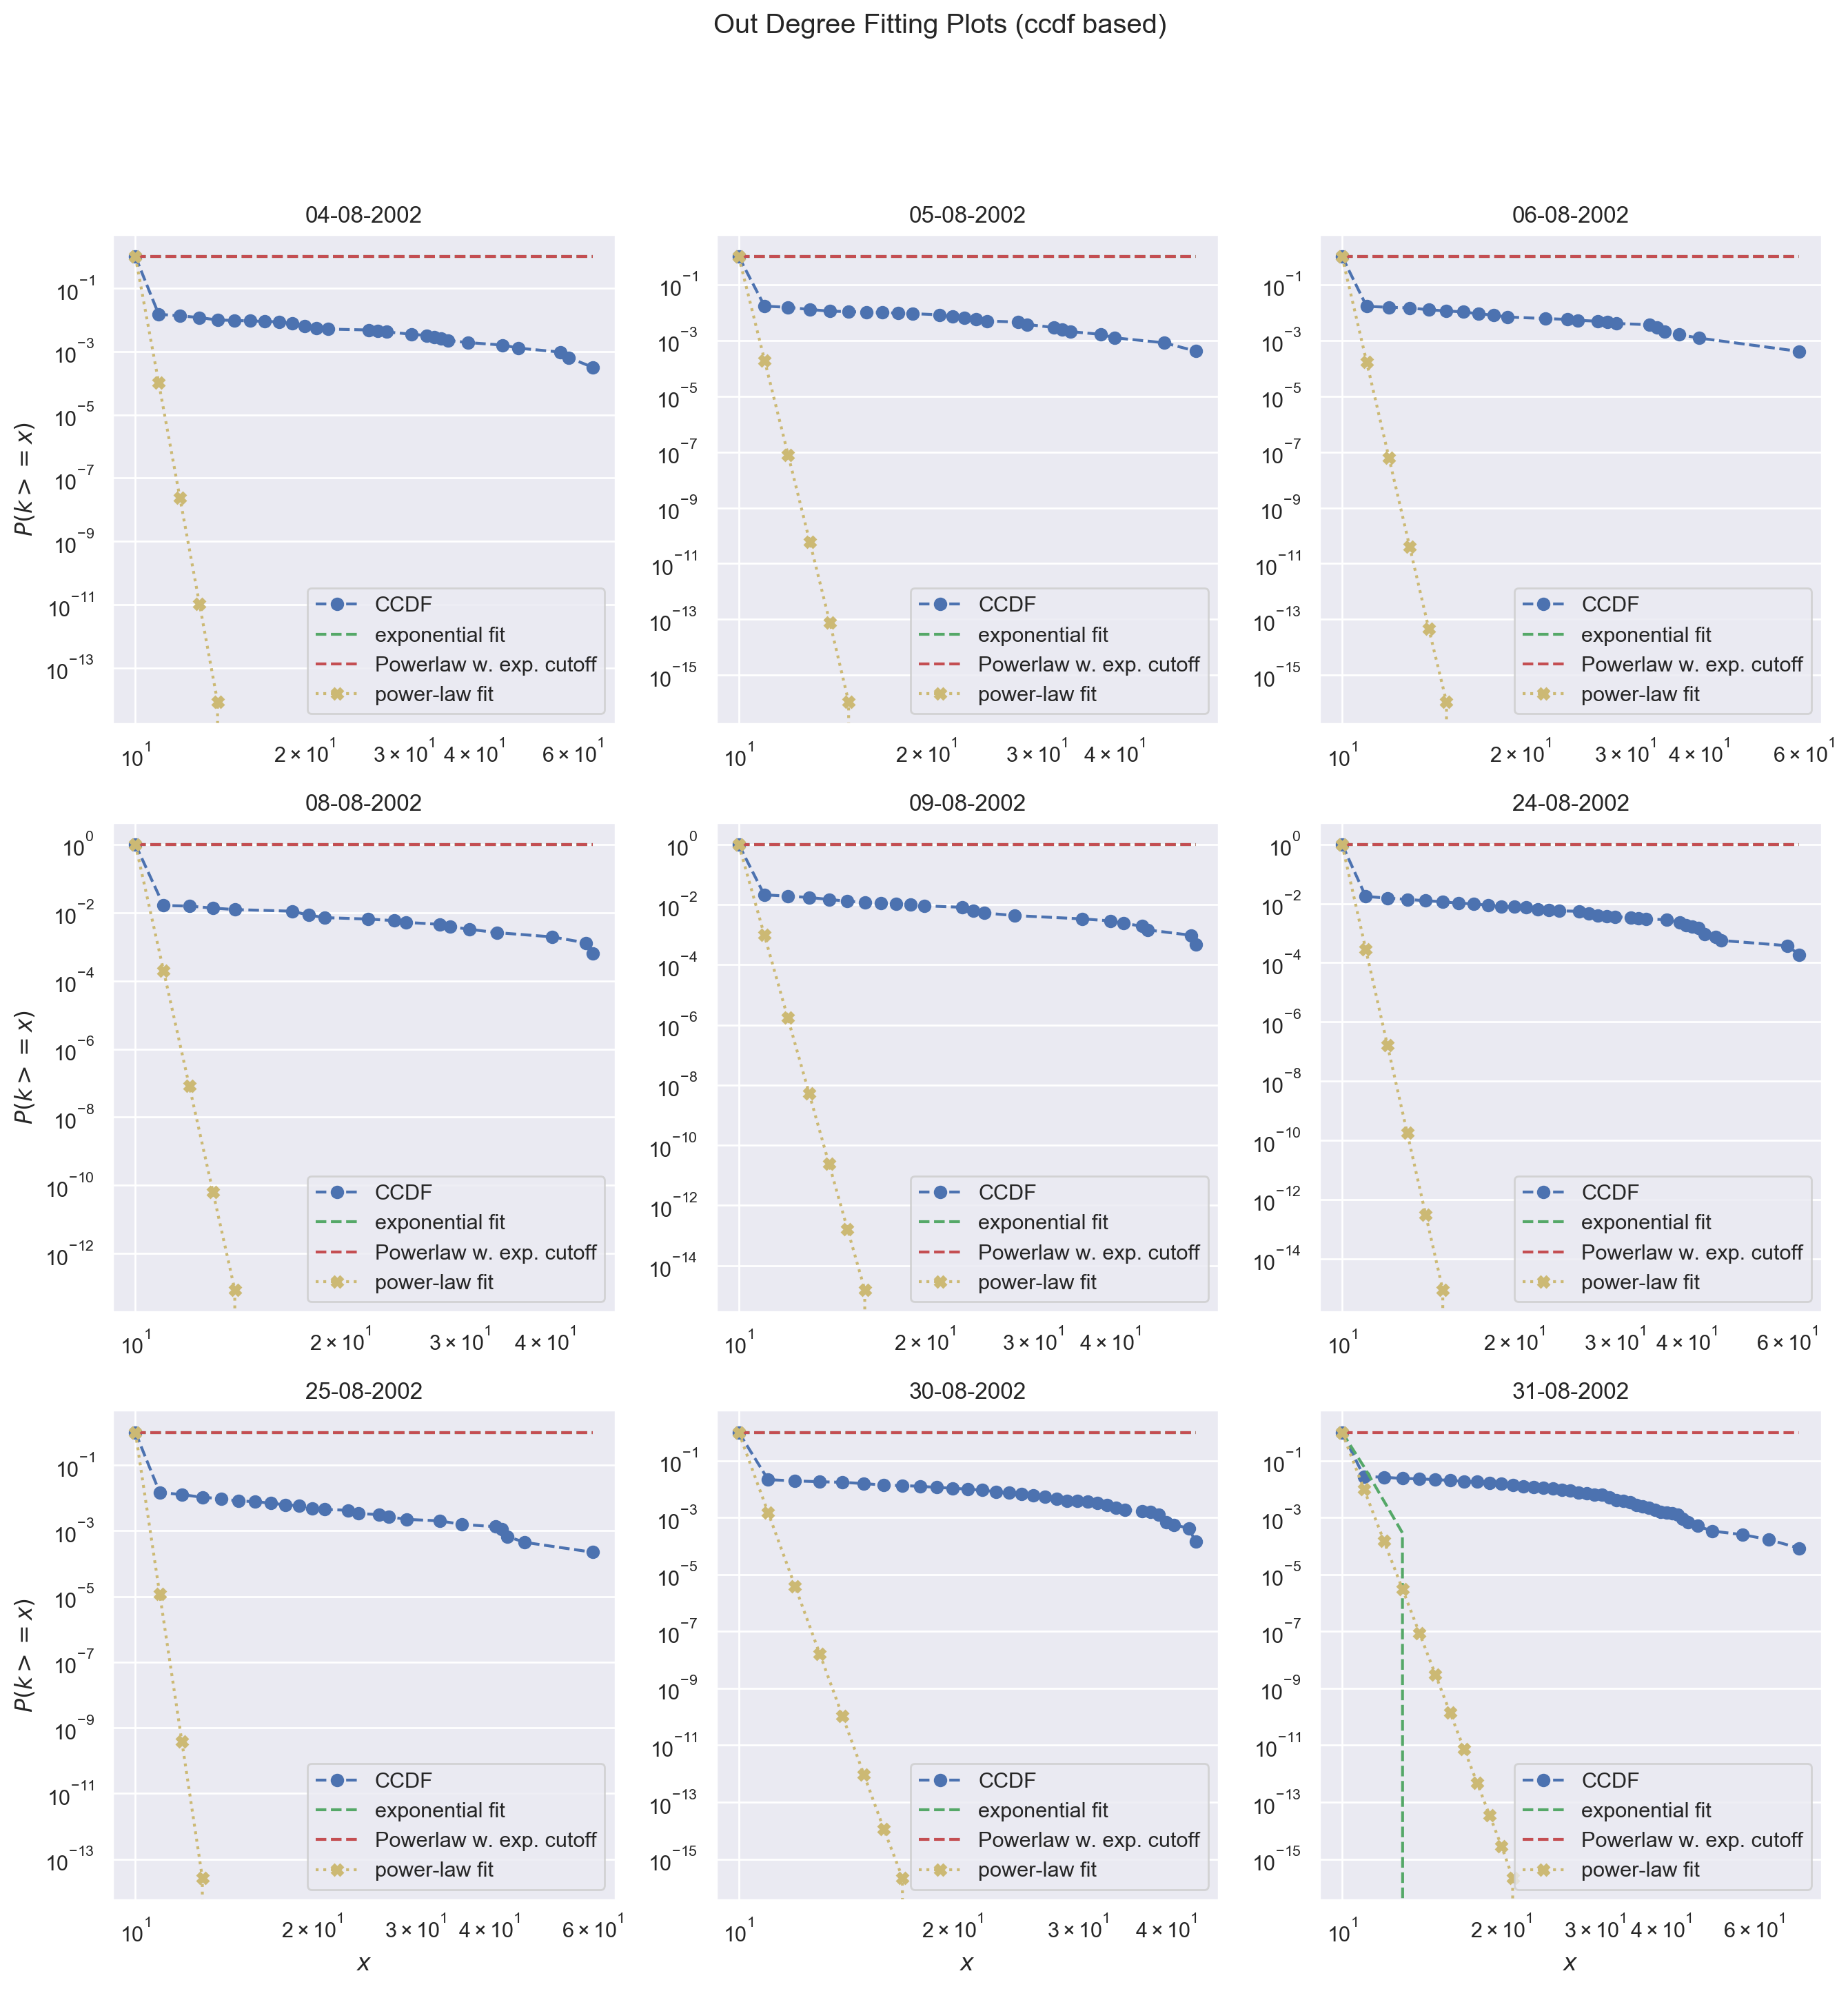

In [12]:
plotter('fitting(ay, i, False)', 'Out Degree Fitting Plots (ccdf based)')           # execute fitting plot

The out degree fittings look highly problematic. We believe this problem could be down stream from the spike in the out degree. Thus we choose to ignore the out degree for now.

For the in degree fitting, the exponential fit is clearly the worst. Both the powerlaw and the powerlaw with exponential cut off, seems to fit the network moderately well. 
For 5 out of 9 graphs gamma is around 3.7. The remaining three graphs has gamma between 6.5 and 7.6. A network that is scale-free has a $\gamma$ between 2 and 3. Our $\gamma$'s thus instead indicates a random regime, meaning that $<k>$ and $<k^2>$ is finite. Thus, we expect that the network will be less robust to random failure than an actual scale-free network, but more robust to targeted attacks.

<a id='centrality'></a>
### Centrality Measuress


At the time of crawling the network, two Gnutella protocols were in place (protocols 0.4 and 0.6).
0.4 used query flooding (practically using a breadth-first search to find a file) and 0.6 used query routing (connecting to a super-seeder). It is in unclear to us what protocol
was running on the nodes in our network. The different protocol does change the light through which
the following measures should be viewed. We keep both protocols in mind.

As the plotting of centrality measures are largely the same, we make a plotting function to be used in all three cases:

In [13]:
def centrality(kind, ay, i):
    orignal = D[i]['centrality'][kind]
    config = D[i]['C']['centrality'][kind]
    ay.set_yscale("log")
    ay.plot(orignal[0], orignal[1], 'bo', label='Original Graph')
    ay.plot(config[0], config[1], 'ro', label='Configuration Model')
    if i >= 6:
        ay.set_xlabel(r'$c$')
    if i in [0, 3, 6]:
        ay.set_ylabel(r'$P(c)$')


Together with our network's centrality measurements, we will plot the same measurements for the configuration model. This is done to figure out to what extent the network's centrality measures are idiosyncratic to the network itself (as opposed to being a consequence of the degree distribution). A configuration model is a useful tool for this as it has the same degree distribution as the one it is built from, but the given edges from a node are drawn to random nodes. If the Gnutella network's centrality plots follow those of the configuration model, we can assume edges are made randomly.

<a id='betweenness'></a>
#### Betweenness centrality

The betweenness centrality of a node *a* describes how large a portion of the shortest paths between any two other nodes, *b* and *c*, go through *a*. We plot this measure as we find it interesting from the perspective of robustness. If the goal is to dismantle the network, it is effective to remove the nodes through which most information flood, making the paths to information longer or worst case even non-existing.

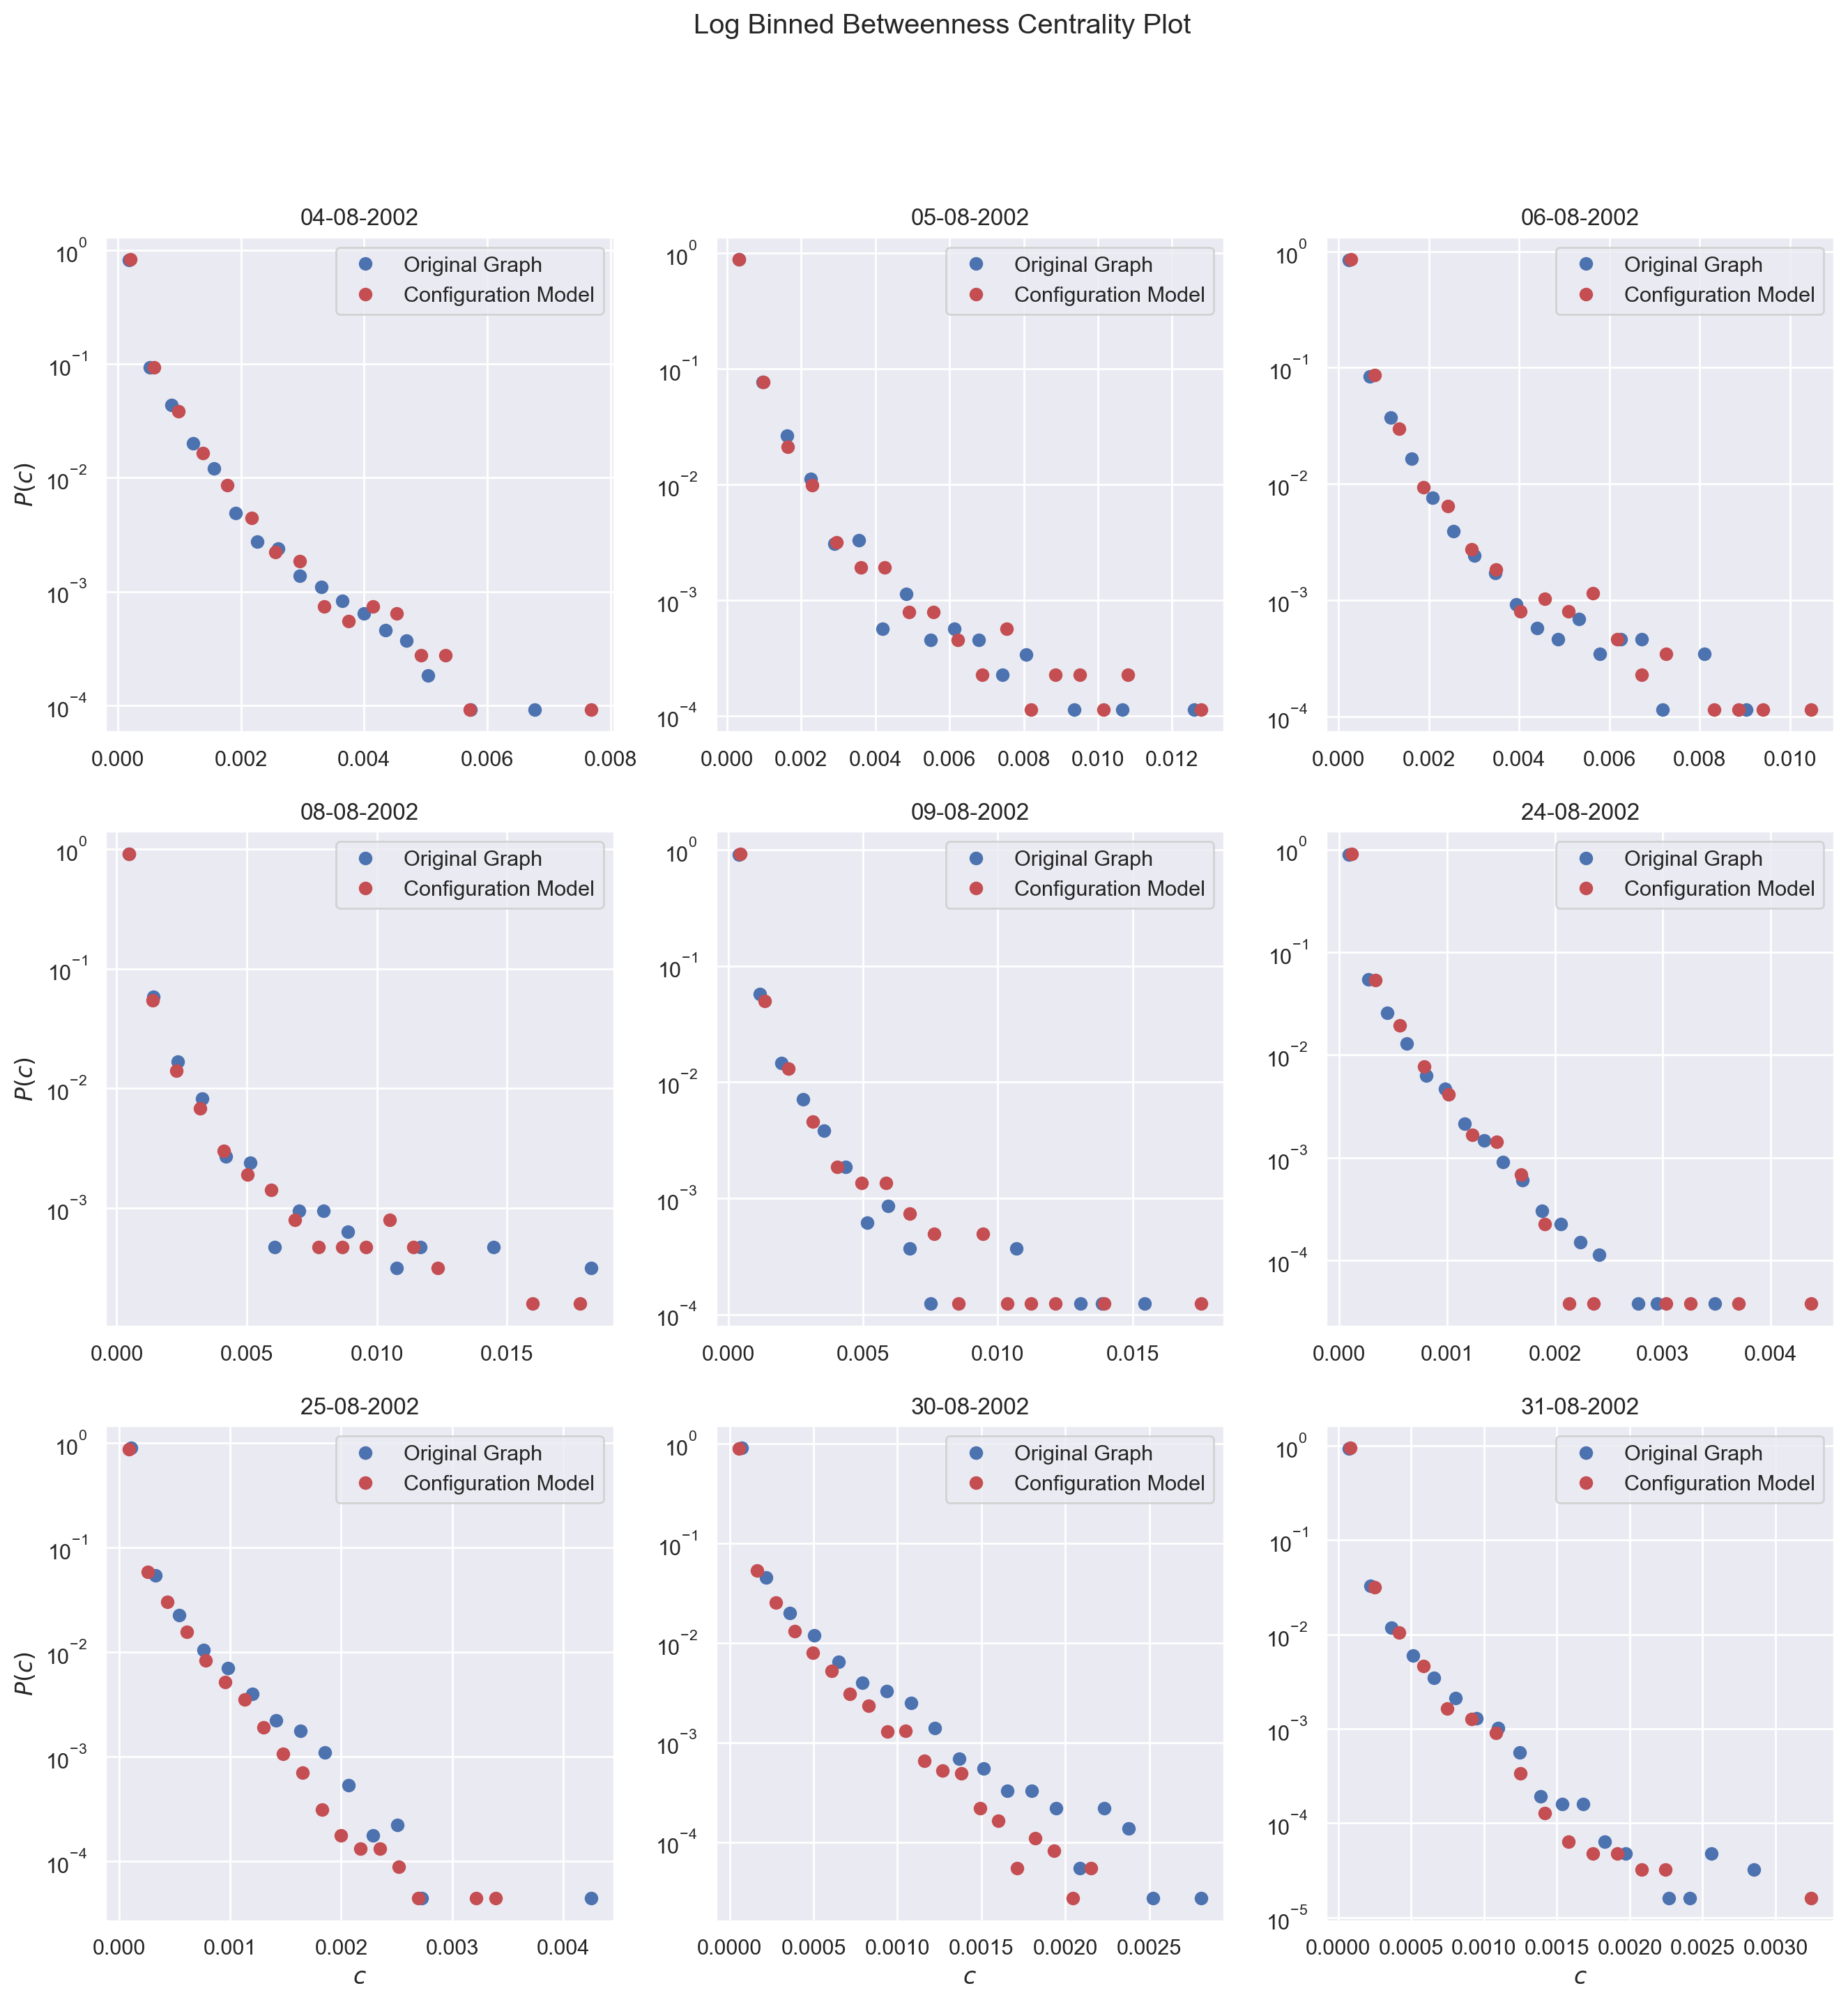

In [14]:
plotter('centrality("betweenness", ay, i)', 'Log Binned Betweenness Centrality Plot')

As the y-axis is logarithmic, this plot tells us that betweenness centralities in the vicinity of that of the largest are quite rare. This could mean a quick drop off in the effectiveness of targeted attacks by betweenness. We see no consistent deviation between the original graph and the configuration model for this metric across plots.

<a id='closeness'></a>
#### Closeness centrality

Closeness centrality measures the length of the shortest distance between all nodes in the network and assigns a value given that distance, a higher value meaning shorter distance. For both query routing and query flooding, the closeness centrality is a relevant metric, because both requests have a Time To Live (TTL) of 6. Thus any file present on a node further away than that would be unavailable to a node.

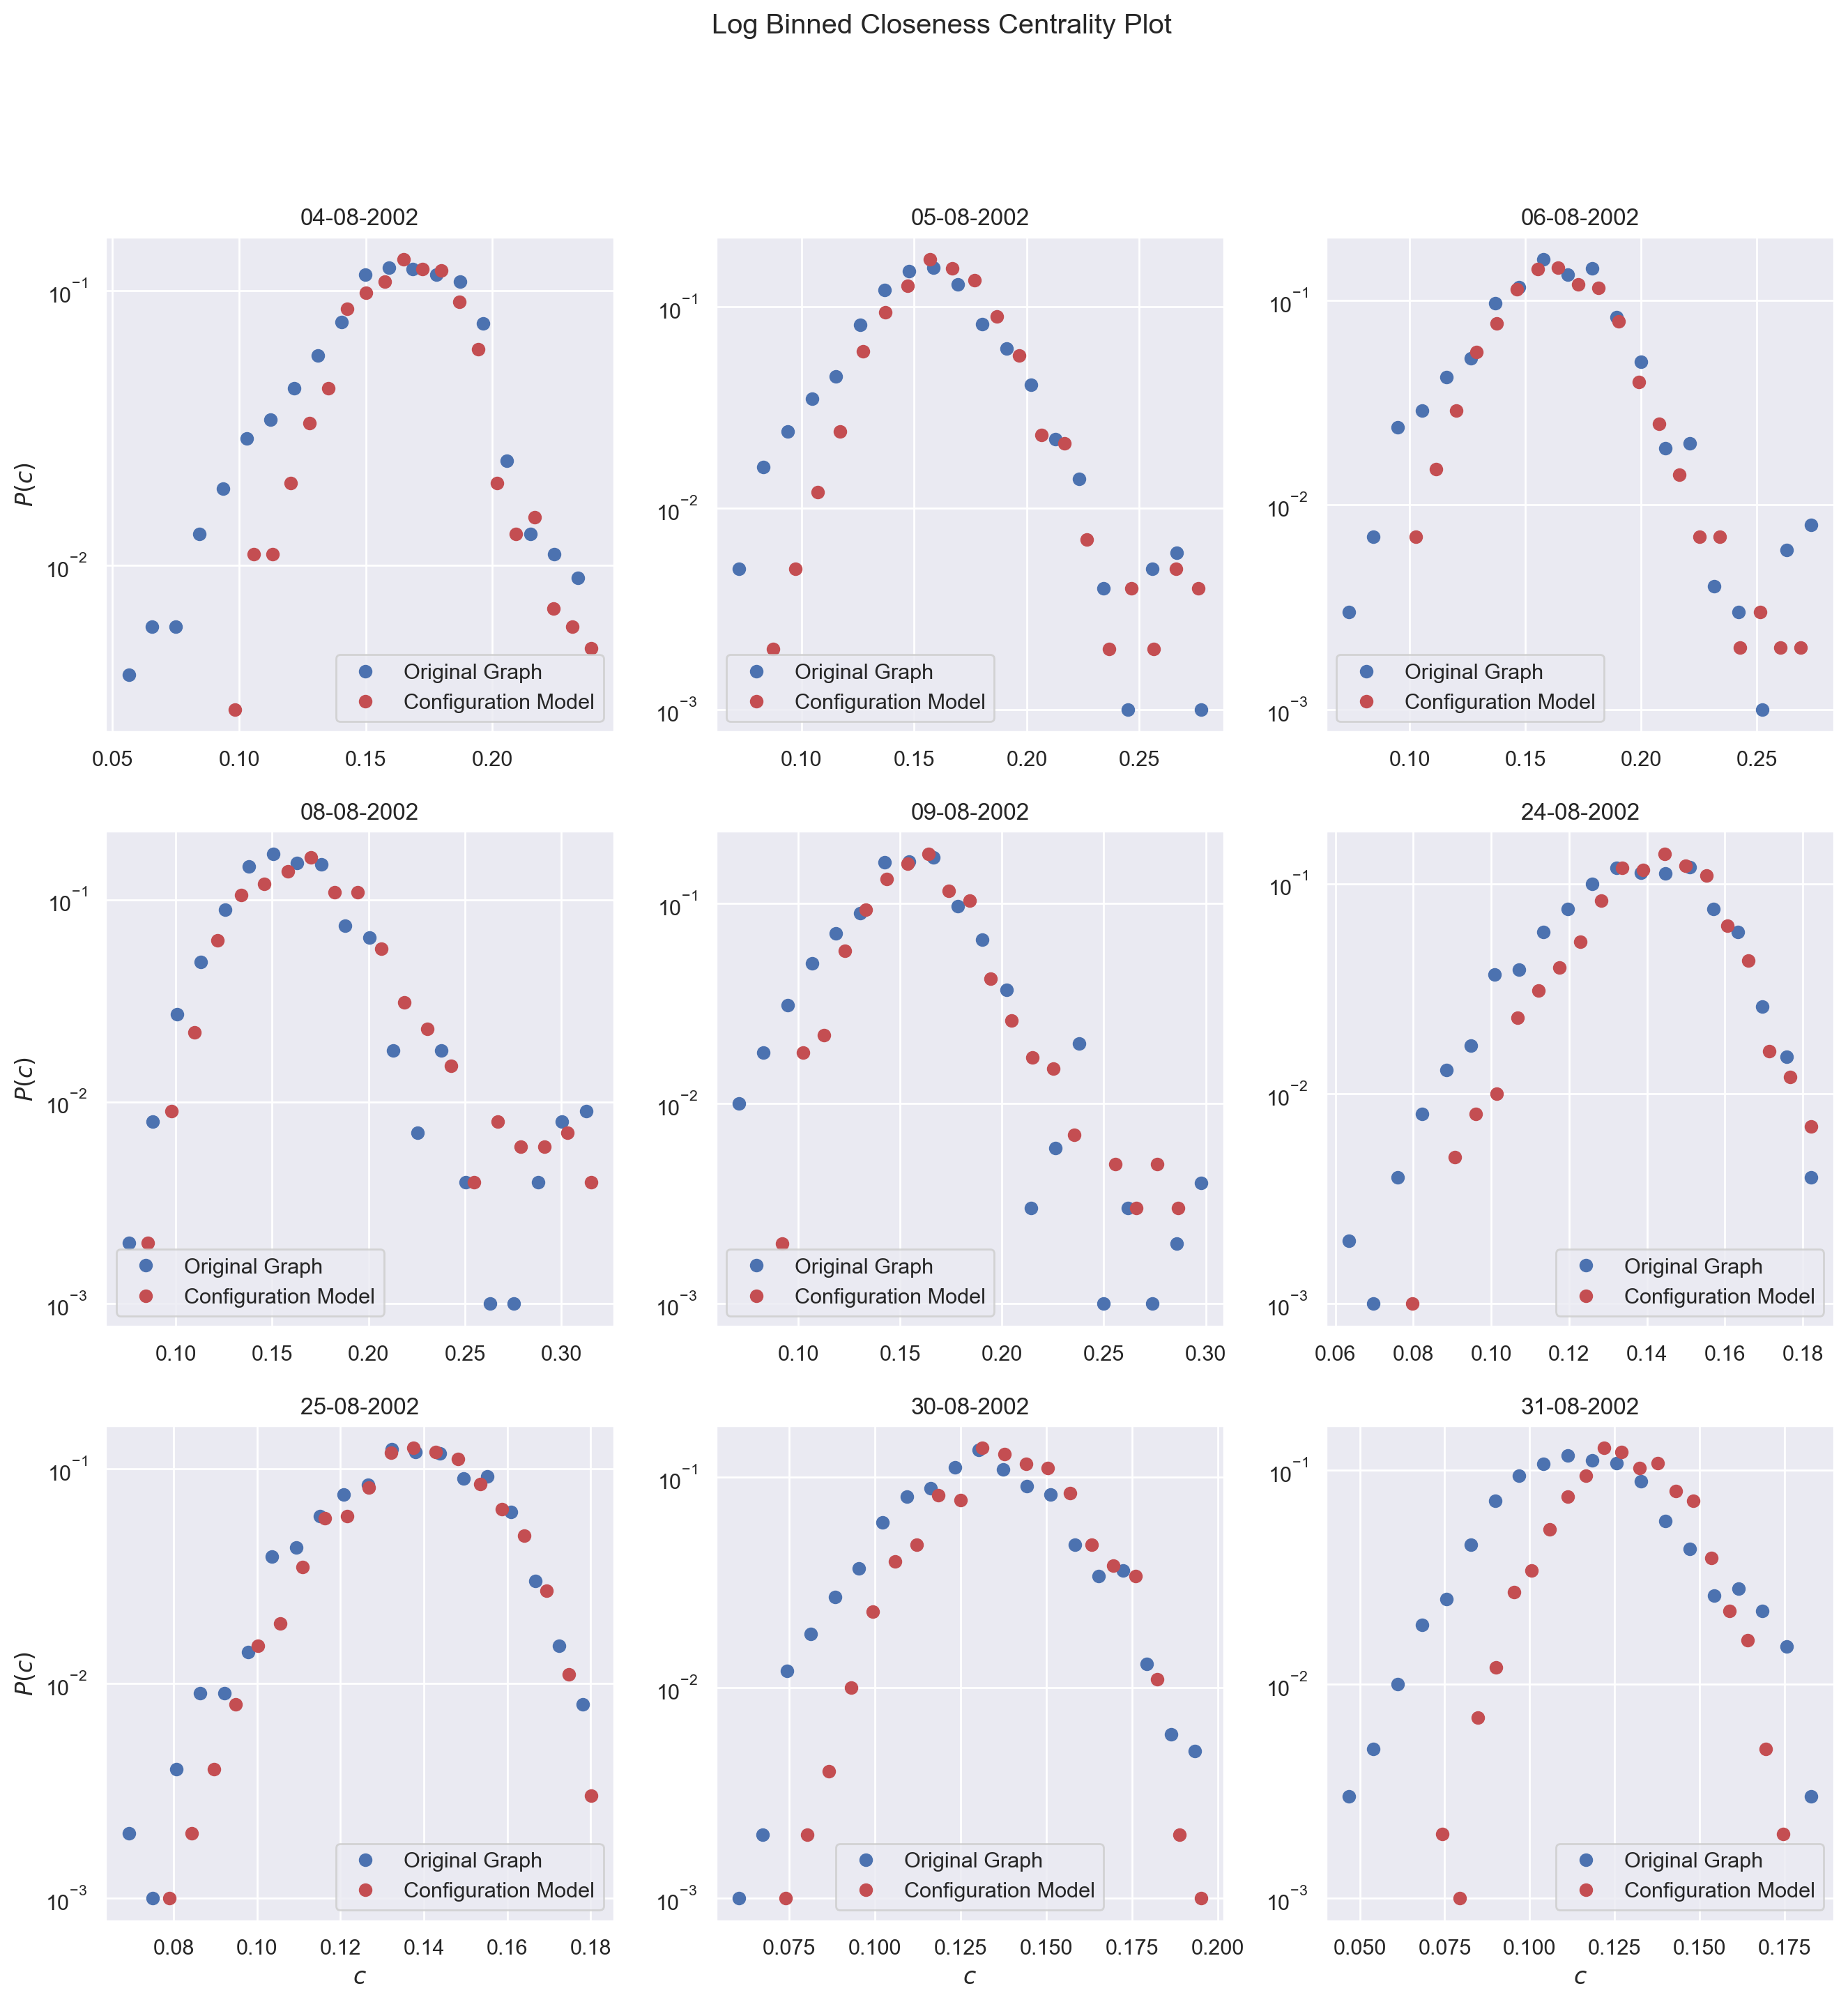

In [15]:
plotter('centrality("closeness", ay, i)', 'Log Binned Closeness Centrality Plot')

The plot shows us a somewhat bell-curved distribution of closeness centrality (keep in mind the log y-scale). We thus assume this centrality measure to be Gaussian. Notably, lower values for this metric is less common for the configuration model.

<a id='eigenvector'></a>
#### Eigen vector centrality

Eigenvector centrality is a way of measuring the importance of the connections a node has. If it is connected to high scoring nodes, it gets a higher eigenvector centrality than if it was connected to an equal amount of another nodes that had a lower score.

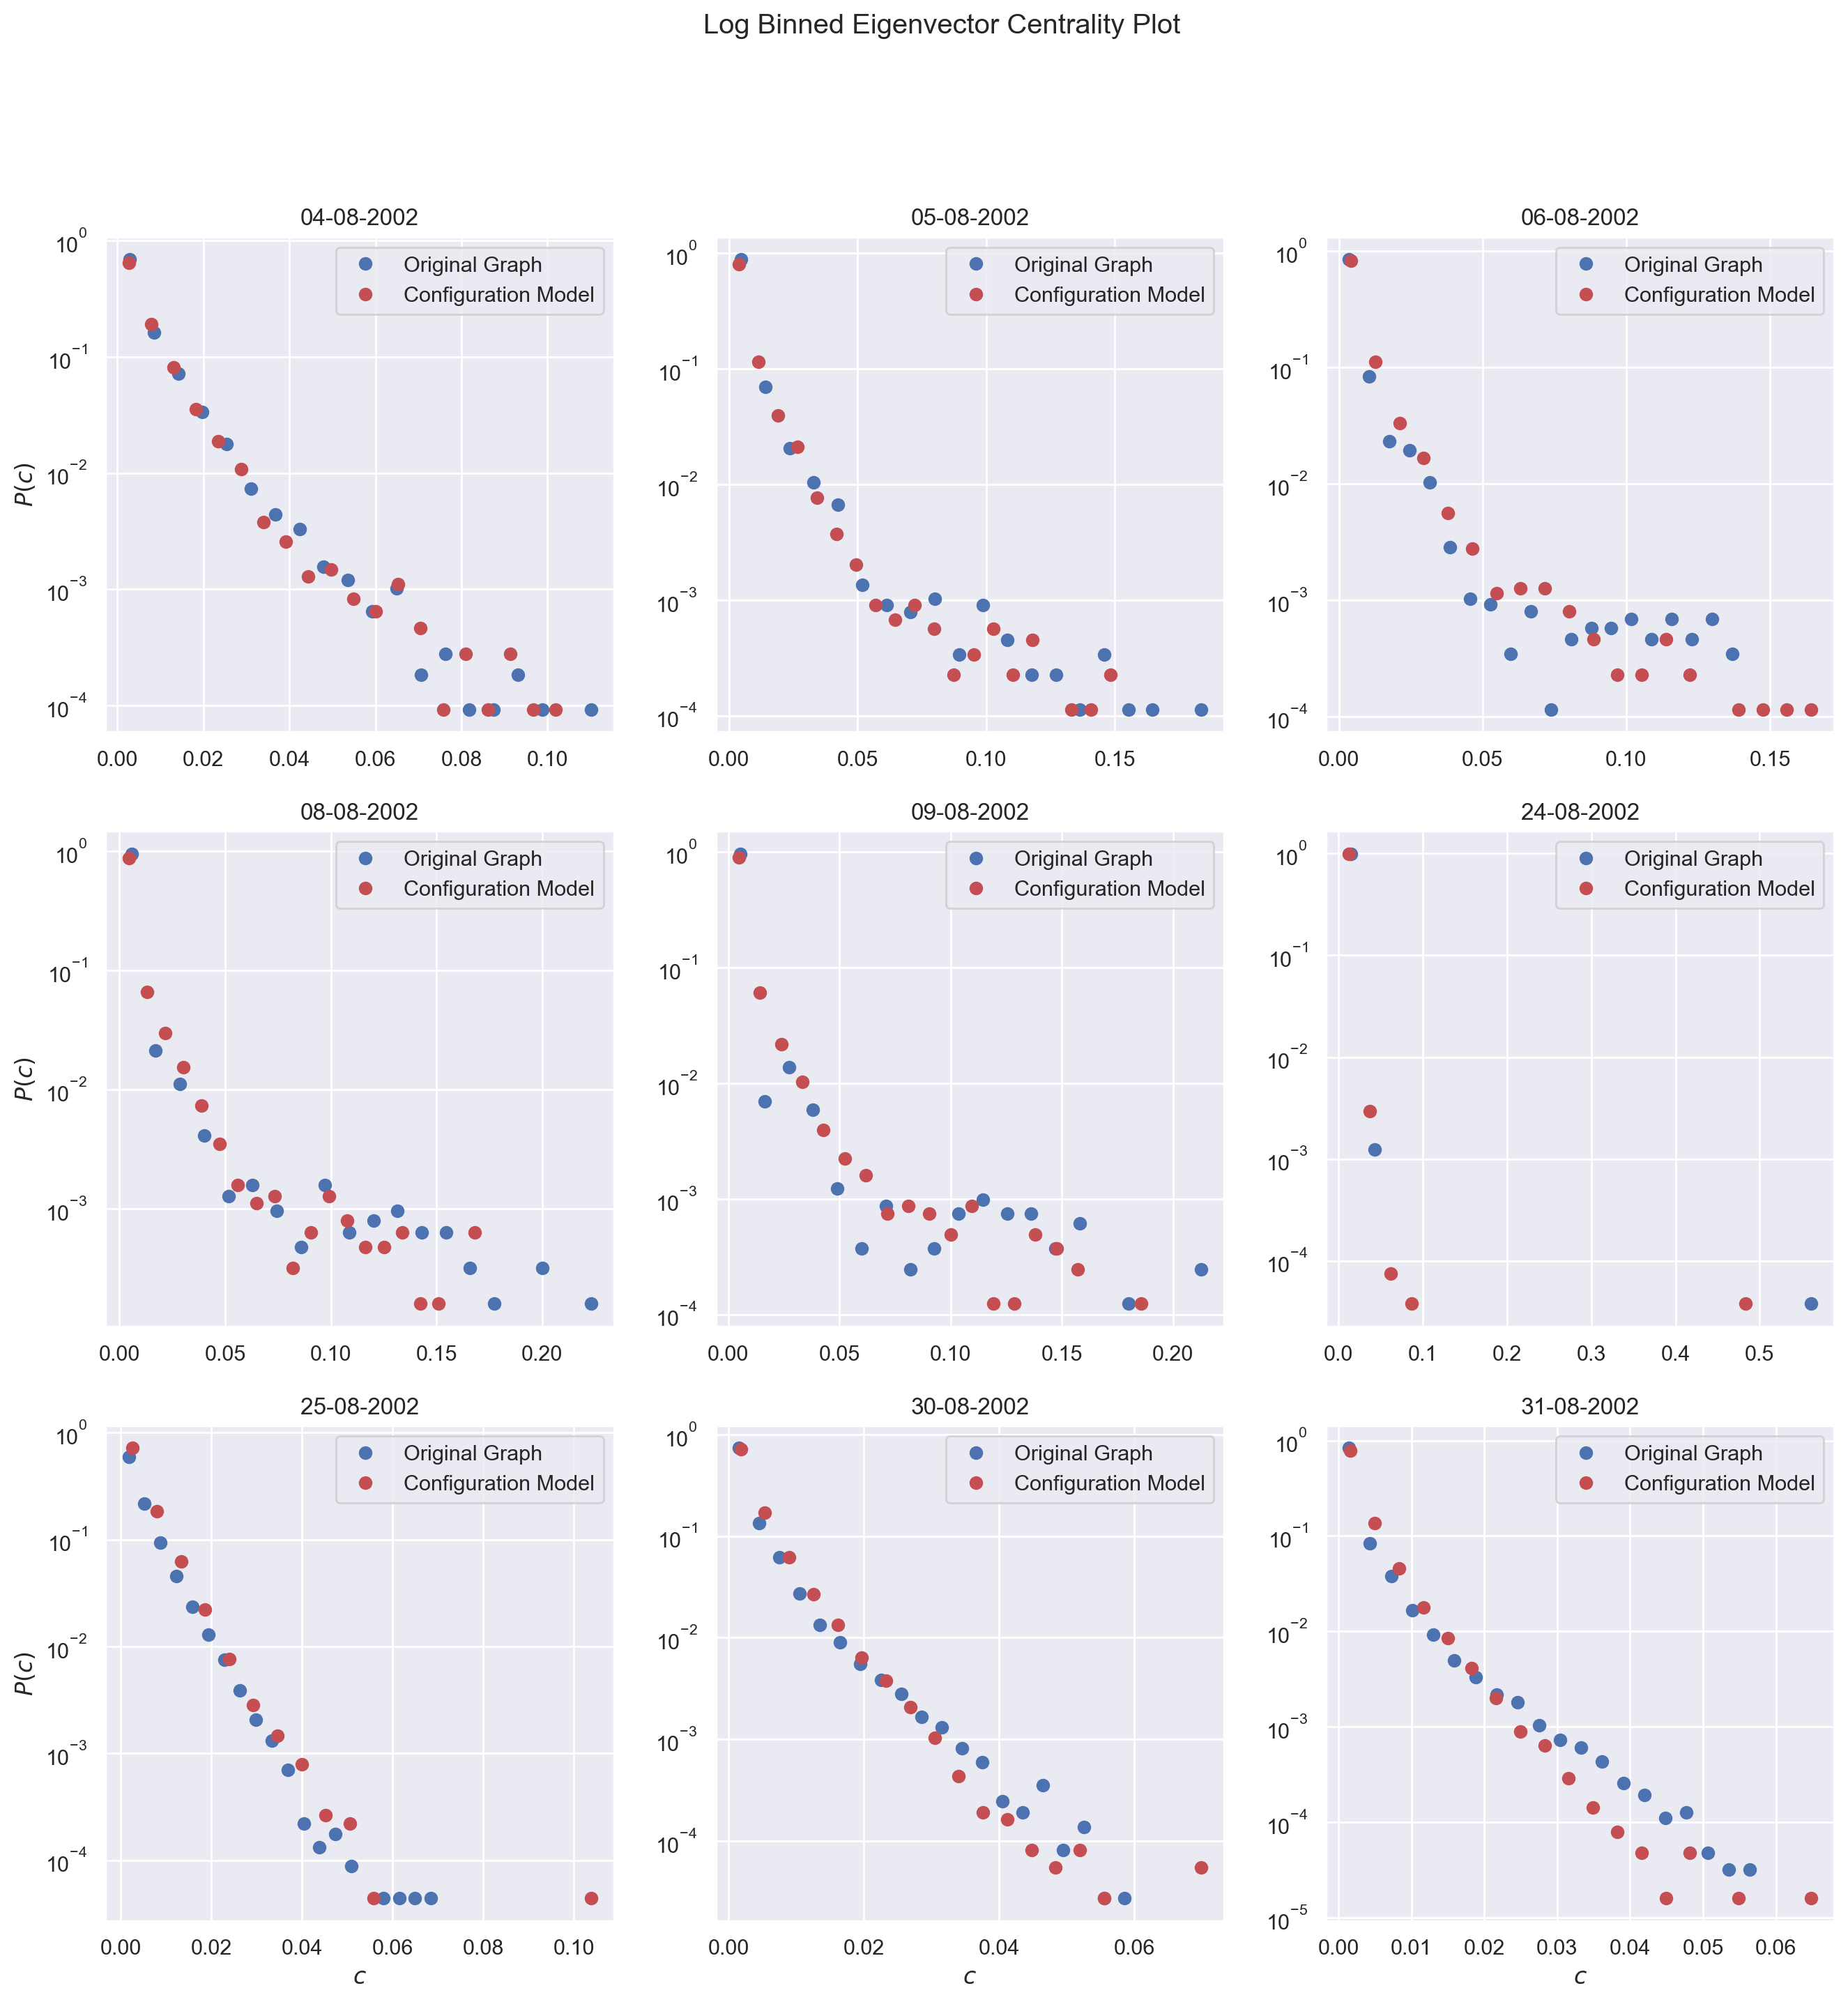

In [16]:
plotter('centrality("eigenvector", ay, i)', 'Log Binned Eigenvector Centrality Plot')

Though similar to betweenness centrality, the eigenvector centrality seems to show a somewhat quicker drop-off frequency. This indicates that eigenvector centrality might be a less effective way to attack the network than targeting betweenness. We will discover this in the robustness section. We see no consistent deviation between the original graph and the configuration model for this metric across plots.

<a id='others'></a>
### Other metrics

Various other of the network metrics follow.

First, we present a measurement of degree assortativity. It is used to examine degree correlation between nodes to see if nodes with *k*-degree link with other nodes of the same degree or the other way around.

A network is assortative for $-1 \leq r < 0$, disassortative for $0 < r \leq 1$, and neutral for $r =0$. Given our network, we do not expect to see degree correlation, therefore the degree correlation will be around 0.

Text(0.5, 1.0, 'Degree Correlation')

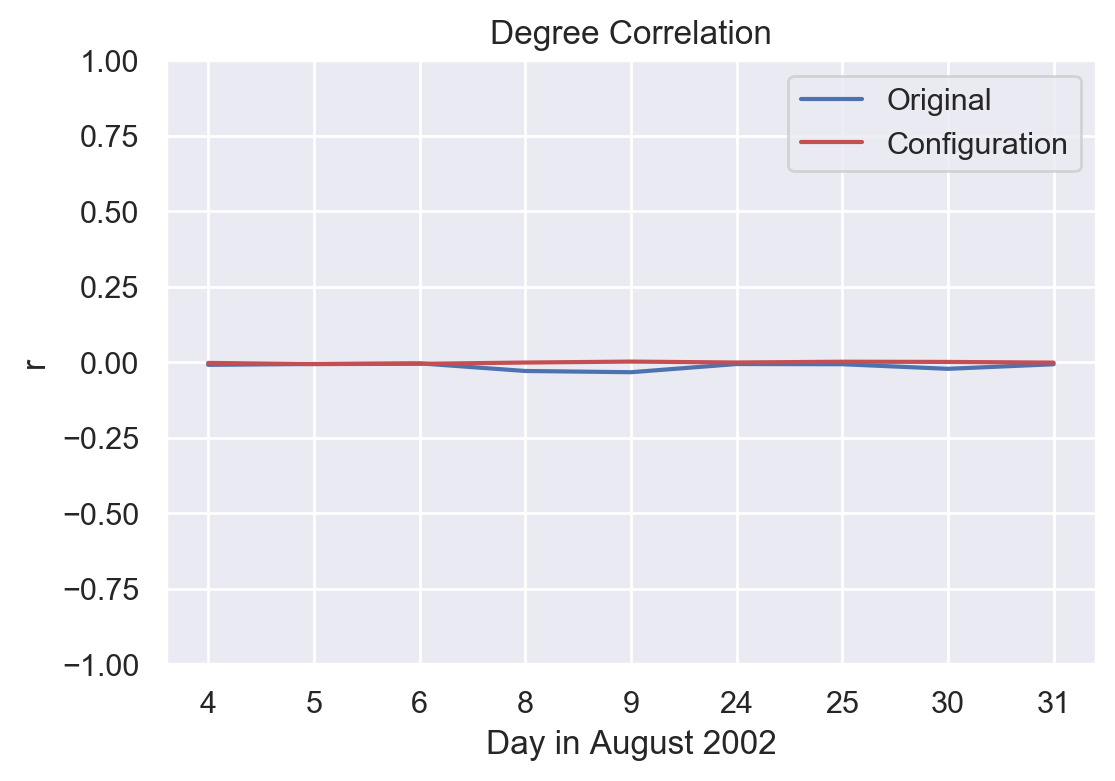

In [17]:
#print("Degree correlation coefficient", 'Original\tConfiguration', sep="\n")

ccs, cccs = [], []
for i in range(len(S)):
    cc = nx.degree_pearson_correlation_coefficient(S[i]); ccs.append(cc)
    ccc = nx.degree_pearson_correlation_coefficient(C[i]); cccs.append(ccc)
    #print(f"{round(cc, 3)} \t\t {round(ccc, 3)}")
    
plt.ylim([-1, 1])
plt.plot(ccs, label='Original', color='b')
plt.plot(cccs, label='Configuration', color='r')
plt.legend(); plt.xticks([i for i in range(9)], dates)
plt.xlabel('Day in August 2002'); plt.ylabel("r"); plt.title('Degree Correlation')

As seen on the graph, the original network follows the configuration model, which hovers around 0, indicating no correlation between degrees.

As explained in [closeness centrality](#closeness), an average shortest path that is not much bigger than 6 is important for the network, as the ping a node sends out has a TTL of 6. Therefore, if the average shortest path is too big, a user will rarely acquire the requested information. To see if the Gnutella network functions optimally in this regard, we look at the average shortest path of the 9 snapshots.

Text(0.5, 1.0, 'Plot of average shortest paths')

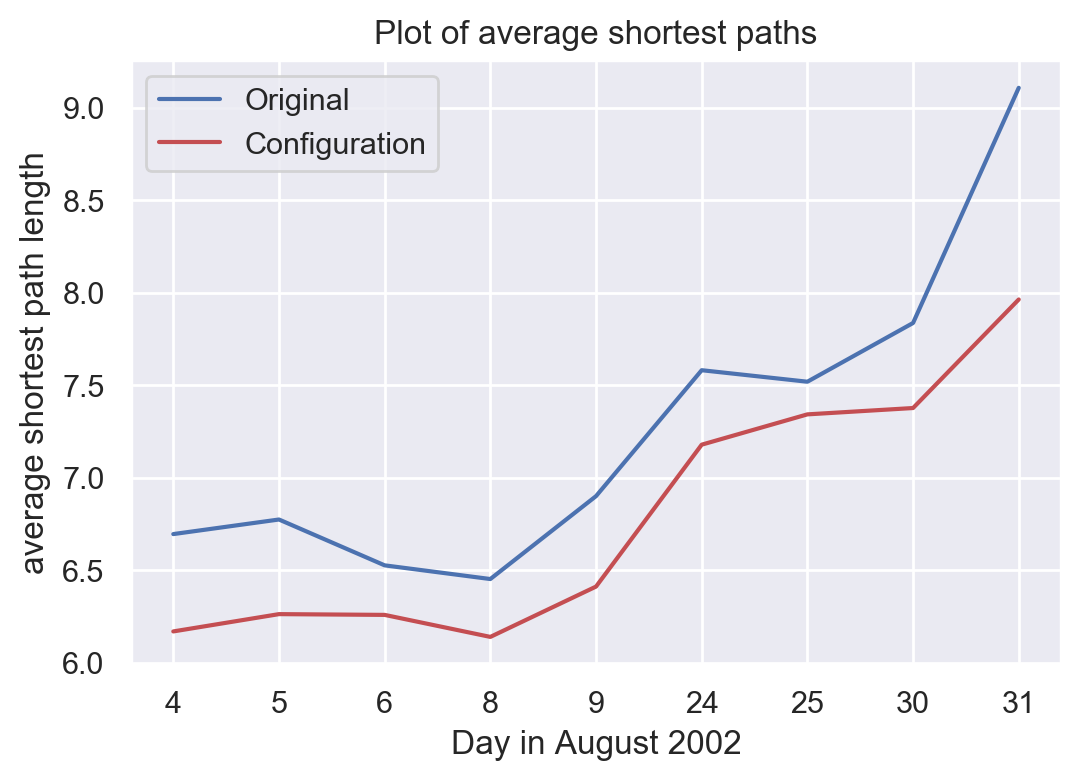

In [18]:
#print("Average shortest path", 'Original\tConfiguration', sep='\n')
g = [D[i]['shortest'] for i in range(len(D))]; plt.plot(g, color='b', label='Original')
c = [D[i]['C']['shortest'] for i in range(len(D))]; plt.plot(c, color='r', label='Configuration')
plt.legend(); plt.xticks([i for i in range(9)], dates); plt.xlabel('Day in August 2002');
plt.ylabel("average shortest path length"); plt.title('Plot of average shortest paths')

#plt.plot(sps, label='Original', color='b'); plt.plot(csps, label='Configuration', color='r');

The highest average shortest path is 9, which tells us that this network is obviously not a social network. Instead, a network build around the internet to reach computers with a relatively low amount of steps. The average shortest path varying between 6 and 9 indicates to us (with the assumed Gaussianness of the closeness centrality in mind) that more than half of the network could be inaccessible to the average node.

Furthermore, it looks like the average shortest path grew for each day. This is likely a feature of the degree distribution as the blue configuration model line echoes that of the original’s red. Notably, the original graph consistently has a slightly higher value for this metric. We do not know why this is. This fact seems to run counter to the purpose of the network of making computers accessible to one another.

<a id='robustness'></a>
### Robustness


Cursory research on the Gnutella network online describes it as inefficient and problematic.
Robustness is thus interesting. In the [fitting](#fitting) section, we learned that the Gnutella network is not scale-free, but random. Scale-free networks have the property of being robust to random failures. This stems from $<k^2>$ not being finite in a scale-free network; you would have to remove nearly all nodes to break the network. This is not how it always works in practice, but instead, a lower $\gamma$ means higher robustness to random failure. As we also learned in the [fitting](#fitting) section, the $\gamma$ value of the Gnutella network was not far from that of a scale-free one on in degree. This could indicate that while it is classified as a random network, it could be relatively robust to random failure, as the Gnutella network has a $\gamma$ between 3.5 and 8. Because of this, we expect relatively good robustness against random failure and the critical threshold for an attack to be low for the graphs with low gamma. 

To begin with we perform random failure on the network both on nodes and edges. We expect that these will behave simularly.

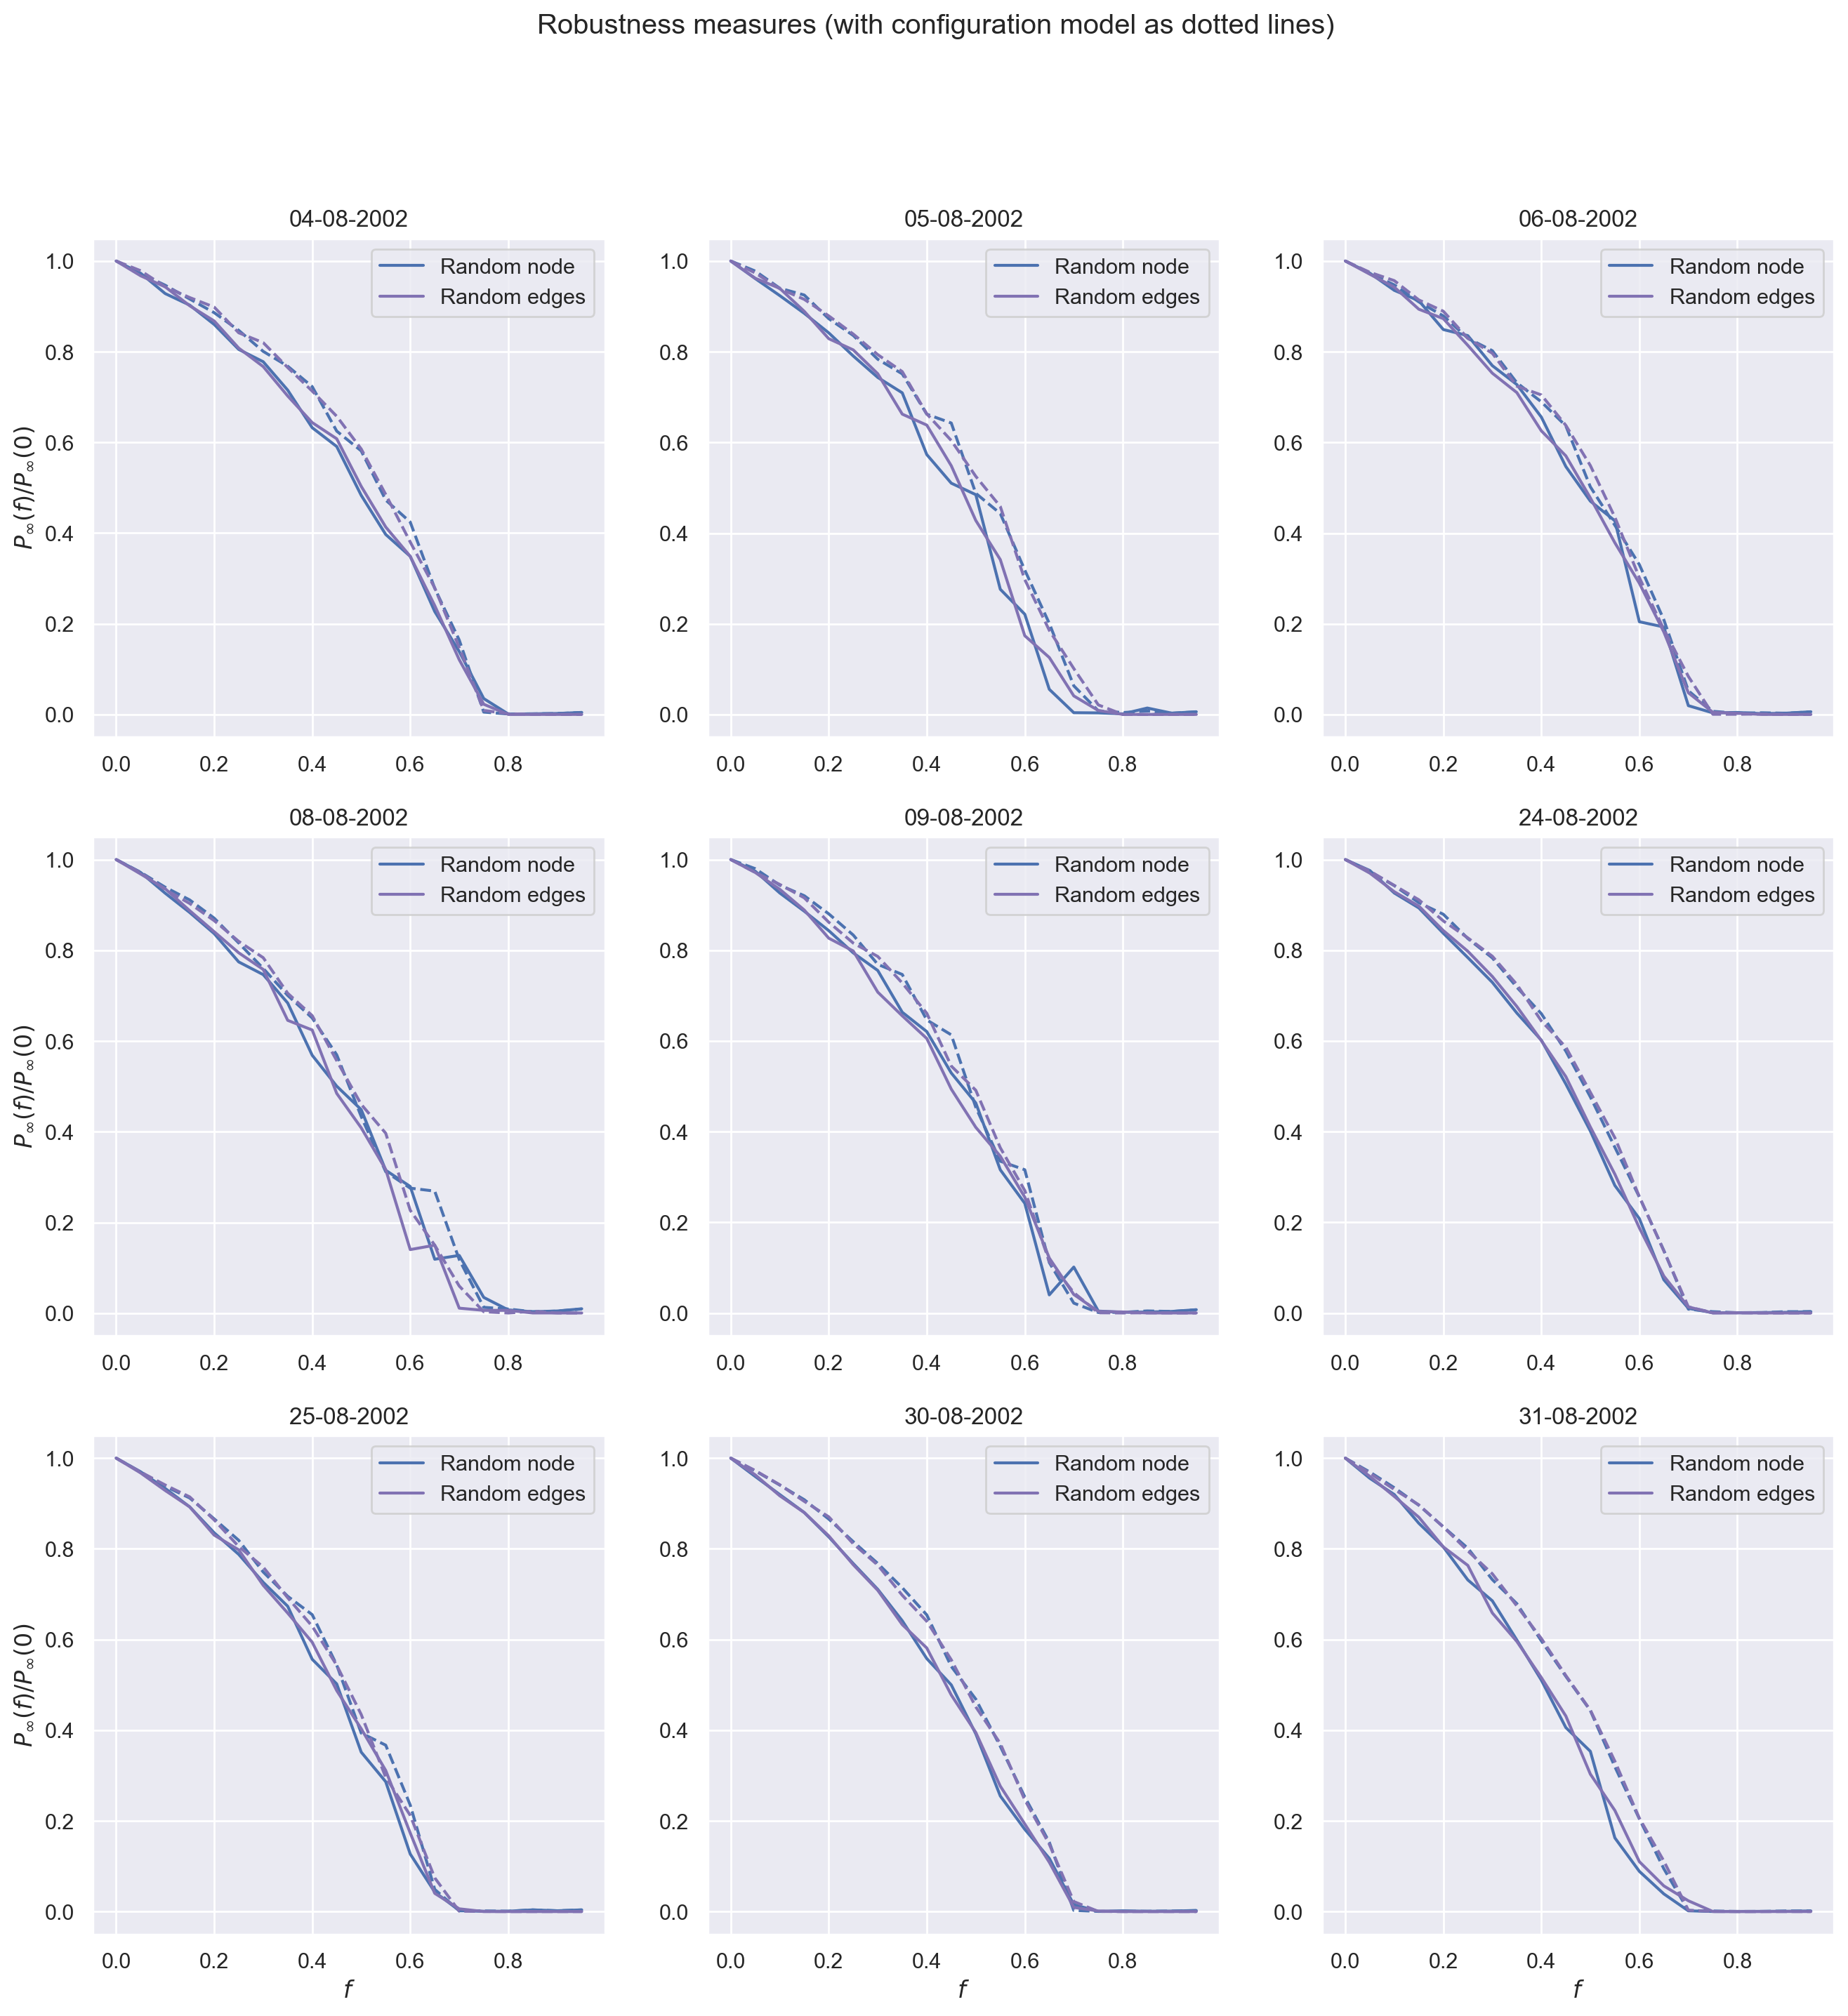

In [19]:
def robustness(ay, i):
    kinds = ['Random node', 'Random edges']; colors = 'bm'
    _G = D[i]['robustness']
    _C = D[i]['C']['robustness']
    _G = [_G[0], _G[-2], _G[-1]]
    _C = [_C[0], _C[-2], _C[-1]]
    for j in range(len(_G)-1):
        exec(f"ay.plot(_G[-1], _G[j], colors[j], label='{kinds[j]}')")
        exec(f"ay.plot(_C[-1], _C[j], colors[j], linestyle='--')")
        if i >= 6:
            ay.set_xlabel(r'$f$')
        if i in [0, 3, 6]:
            ay.set_ylabel('$P_∞(f)/P_∞(0)$')
plotter('robustness(ay, i)', 'Robustness measures (with configuration model as dotted lines)')

Our expectation of simular behaviour is thus confirmed and we continue on using only the random node failures.

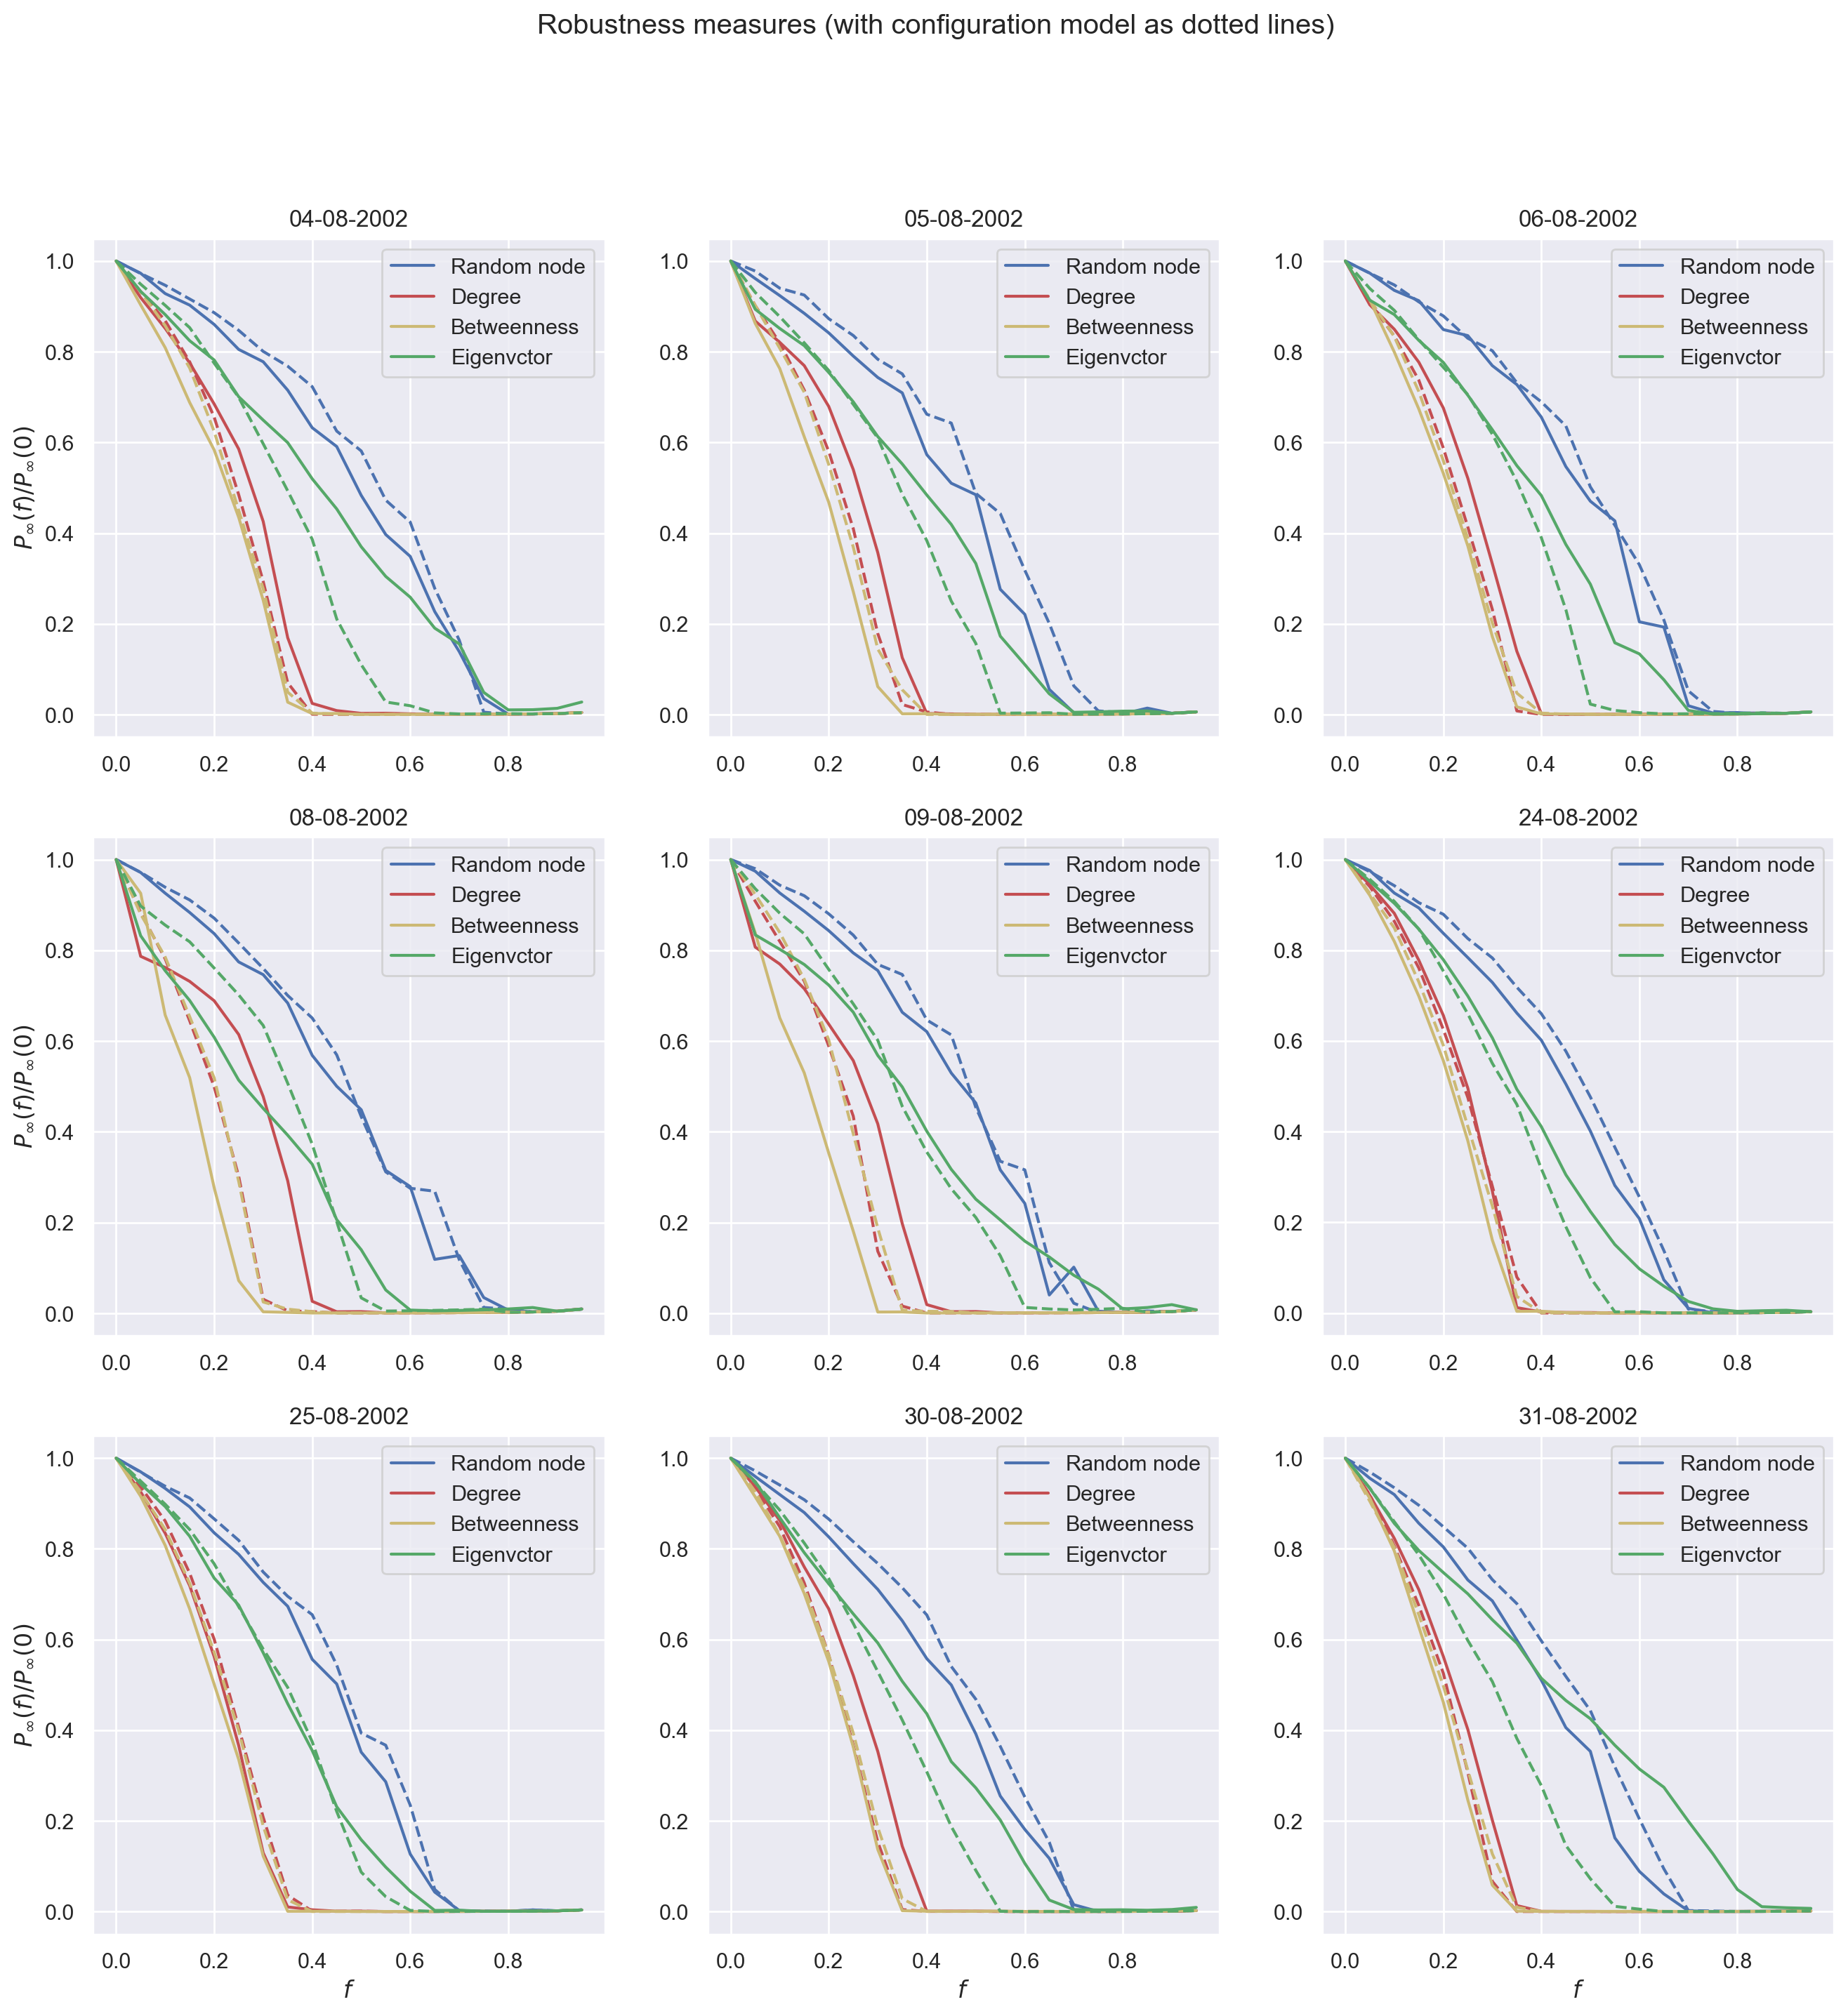

In [20]:
def robustness(ay, i):
    kinds = ['Random node', 'Degree', 'Betweenness', 'Eigenvctor']; colors = 'brygm'
    _G = D[i]['robustness']
    _C = D[i]['C']['robustness']
    for j in range(len(_G)-2):
        exec(f"ay.plot(_G[-1], _G[j], colors[j], label='{kinds[j]}')")
        exec(f"ay.plot(_C[-1], _C[j], colors[j], linestyle='--')")
        if i >= 6:
            ay.set_xlabel(r'$f$')
        if i in [0, 3, 6]:
            ay.set_ylabel('$P_∞(f)/P_∞(0)$')
plotter('robustness(ay, i)', 'Robustness measures (with configuration model as dotted lines)')

Calculating critical threshold for random failure:

In [21]:
for i,x in zip(firstMoment,[4,5,6,8,9,24,25,30,31]):
    print(f"Critical value for random failure snapshot {x}: {round(1-(1/i),3)}") 

Critical value for random failure snapshot 4: 0.864
Critical value for random failure snapshot 5: 0.861
Critical value for random failure snapshot 6: 0.862
Critical value for random failure snapshot 8: 0.848
Critical value for random failure snapshot 9: 0.844
Critical value for random failure snapshot 24: 0.797
Critical value for random failure snapshot 25: 0.793
Critical value for random failure snapshot 30: 0.792
Critical value for random failure snapshot 31: 0.788


As expected, we see that the network is relatively robust to random attacks, while significantly less so to degree and betweenness based attacks. As predicted from the eigenvector centrality plot, the eigenvector approach for attack is slightly less effective than that of betweenness. 

The results seem consistent across time; it seems likely that the critical threshold for actual real world Gnutella network was around 0.8 for random failure and 0.3 for the most effective targeted attacks.

As mentioned in Appendix A and in Future Work, more effective attack methods do exist.

<a id='conclusion'></a>
## Conclusion

After performing exploratory data analysis to see how and why we should attack the network, we performed a random failure on degree and edges, as well as betweenness- and eigenvector centrality attacks and an attack based on degree. We found that while the Gnutella network is not scale-free, it inherits some of the same properties due to its relatively low $\gamma$ and its somewhat high $<k^2>$. These properties are: Robust to random failures with a critical threshold around 0.8, but given a targeted attack on the network, it succumbs moderately fast, with a critical threshold of 0.3.

The mentioned discoveries seem to be true across time. These conclusions are perhaps not representative of the real world Gnutella network, due to our network data being of somewhat low quality as can be seen with the spike in out degree and the problems with fitting.

<a id='future'></a>
## Future Work

Though the robustness tests run above are interesting from a network
analytical perspective, practically speaking, other forms of robustnesses
might be more relevant and realistic. Had we had more time we would have explored cascading
failures, giving nodes degree-breaking points and re-connecting edges from
failed nodes.

Another interesting path to pursue, as it relates to robustness could be to
simulate spamming the network. This was actually something the Gnutella was
quite vulnerable to: On version 0.4 of the protocol, files were searched for using query flooding (essentially Breadth-First Search). This meant that asking for files that
one knew for sure was not on the network would reach every node within TTL.

<a id='bibliography'></a>
## Bibliography

The Gnutella data sets are downloaded from:
- https://snap.stanford.edu/data/ (name: Internet peer-to-peer networks)

Background information on how the network and how it was scraped is from:
- https://www.academia.edu/2893724/Topology_of_Gnutella_Network_Discovery_and_Analysis
- http://w2w.sourceforge.net/studienarbeit/Report.pdf
- http://www.cs.kent.edu/~javed/class-P2P13F/P2P-L07b-gnutella.pdf

Network science understanding:
- Lecture reading material, mostly http://networksciencebook.com/

<a id='appendix'></a>
## Appendix

### Appendix A

We would liked to attacked the network by in degree as this proved effective in early robustness testing with a critical value in the low 0.2's. However, due to a mistake, we did not manage to include this in our robustness analysis.

### Appendix B

Text(0, 0.5, 'component count')

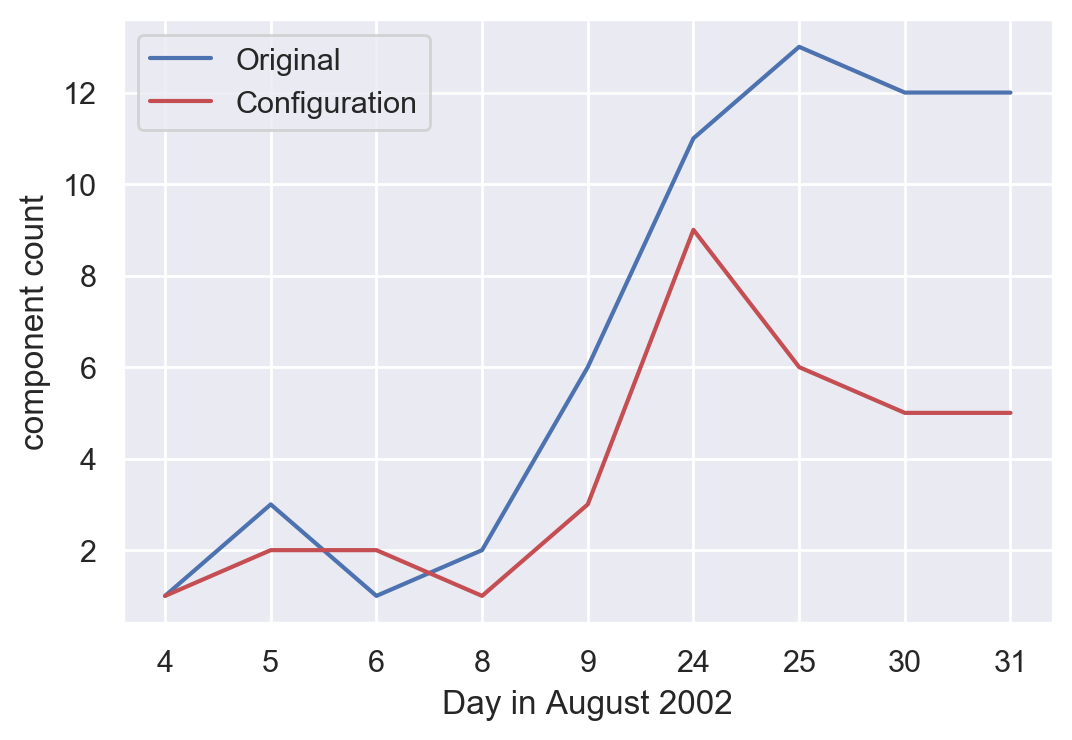

In [22]:
#print("Number of connected components", 'Original\tConfiguration', sep='\n')
 
ccs, cccs = [], []
for i in range(len(S)):
    cc = len(list(nx.weakly_connected_components(S[i]))); ccs.append(cc)
    ccc = len(list(nx.weakly_connected_components(C[i]))); cccs.append(ccc)
    
 #   print(f"{cc} \t\t {ccc}")
    
plt.plot(ccs, label='Original', color='b'); plt.plot(cccs, label='Configuration', color='r');
plt.legend(); plt.xticks([i for i in range(9)], dates);
plt.xlabel('Day in August 2002'); plt.ylabel('component count')

We have chosen not to include connected components in our analysis as it does not make sense. Considering our network, everything would be one connected component. Looking into the small analysis we have done on the connected components, the reason there is more than 1, is because there exists very small components of size 2, which is not important for our discussion.